In [2]:
#%matplotlib notebook
#%matplotlib auto

from scipy import stats
import galpy.potential
from galpy.orbit import Orbit
from astropy import units as u
from galpy.potential import LogarithmicHaloPotential
import numpy as np
from galpy.potential import MWPotential2014,PowerSphericalPotential
#from galpy.potential import FerrersPotential,DehnenBarPotential
import matplotlib.pyplot as plt
#import gala.integrate as gi
#import gala.dynamics as gd
#import gala.potential as gp
#from gala.units import galactic
import astropy.units as u
from orbit_functions import *
import pickle
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from scipy.ndimage import gaussian_filter
from galpy.potential import plotRotcurve
from functools import partial
import emd

from scipy.fft import *
from scipy import interpolate, optimize, signal
from astropy.io import fits
from astropy.table import Table


In [3]:
class Loader():
    o_cache = None
    o_cache_name = None
    oo = None
    new = False

    def load_model(self, model, time, xmin=1000, xmax=3000, phi_range=0.2, maxvr=20):
        
        if model == 'MW_Sgr':
            Rmax=16.
            snap=str(int(np.round(time*100))) if time>=1 else '0'+str(int(time*100))
            df = Table.read('MW_Sgr/disk'+snap+'.fits', format='fits').to_pandas()
            df['X'],df['Y'],df['Z'],df['VX'],df['VY'],df['VZ']=cyl2cart(df['R'],df['phi'],df['Z'],df['VR'],df['Vphi'],df['VZ'])
            ind=df['R']<Rmax
            df=df[ind]    
            x,y,z,VR,Vphi,VZ,R,phi=df['X'],df['Y'],df['Z'],df['VR'],df['Vphi'],df['VZ'],df['R'],df['phi']
            Vphi=Vphi*-1.
            Lz=R*Vphi
        else:
            if self.o_cache_name == model:
                o = self.o_cache
            else:
                file='o_galpy/o_'+model+'.pkl'
                with open(file, 'rb') as f:#for orbits after perturbation
                    o = pickle.load(f)
                self.o_cache = o
                self.o_cache_name = model

            t=time*u.Gyr
            x=o.x(t)
            y=-o.y(t)#in galpy, orbits turn counterclockwise. changing sign of y we turn it into clockwise
            VR=o.vr(t)
            Vphi=o.vphi(t)*o.r(t)
            R=o.r(t)
            Lz=R*Vphi
            phi=o.phi(t)

        indphi=(np.abs(phi)>np.pi-phi_range)&(np.abs(phi)<np.pi+phi_range)
        x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
        indphi=(np.abs(VR)<maxvr)&(Lz>xmin)&(Lz<xmax)
        x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
        DATA = False
        
        return x,y,VR,Vphi,R,Lz,phi

    def load_data(self, xmin=1500, xmax=3500, phi_range=0.4, new=False):
        if self.oo == None or self.new != new:
            path = 'o_galpy/SoS_SH_Gaia_test_GAL6D.fits'
            if new:
                path = 'o_galpy/DR3_SH_ruwe14_fidelity05_pioe5_GAL6D.fits'
            self.oo = Table.read(path, format='fits')
        oo = self.oo
        self.new = new

        VR,Vphi,VZ,x,y,Z,R,phi=np.array((oo['VR'],oo['Vphi'],oo['VZ'],oo['X'],oo['Y'],oo['Z'],oo['R'],oo['phi']))
        Lz=-oo['Vphi']*oo['R']
        phi=-np.deg2rad(phi)
        Vphi=-Vphi
        
        indphi = abs(phi) < phi_range
        x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
        indphi=(Lz>xmin)&(Lz<xmax)
        x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
        
        DATA = True
        return x,y,VR,Vphi,R,Lz,phi

def smooth_bins(x, y, xmin, xmax, binsize):
    binsLZ=np.arange(xmin,xmax,binsize)
    m,xedge,binnumber=stats.binned_statistic(x, y, statistic='mean', bins=[binsLZ]) 
    nx = np.arange(xmin-binsize/2, xmax, binsize)
    xpol = nx + binsize/2
    means = []
    for k in nx:
        rel = y[(k<x) & (x<k+binsize)]
        if len(rel) == 0:
            if len(means) == 0:
                means.append(0)
            else:
                means.append(means[-1])
        else:
            means.append(np.mean(rel))
    ypol = np.array(means)
    return xpol, ypol

l = Loader()
CURMODEL = 'Dhot_log'
#CURMODEL = 'Dhot_log_2perturb'
#CURMODEL = 'Dhotn10_pn10'
#CURMODEL = 'Dhotn_10_pn_10'


0.001
0.101
0.201
0.30100000000000005
0.401
0.501
0.6010000000000001
0.7010000000000001
0.801
0.901
1.001
1.101
1.201
1.301
1.401
1.501
1.601
1.701
1.801
1.901
2.001
2.101
2.201
2.301
2.4010000000000002


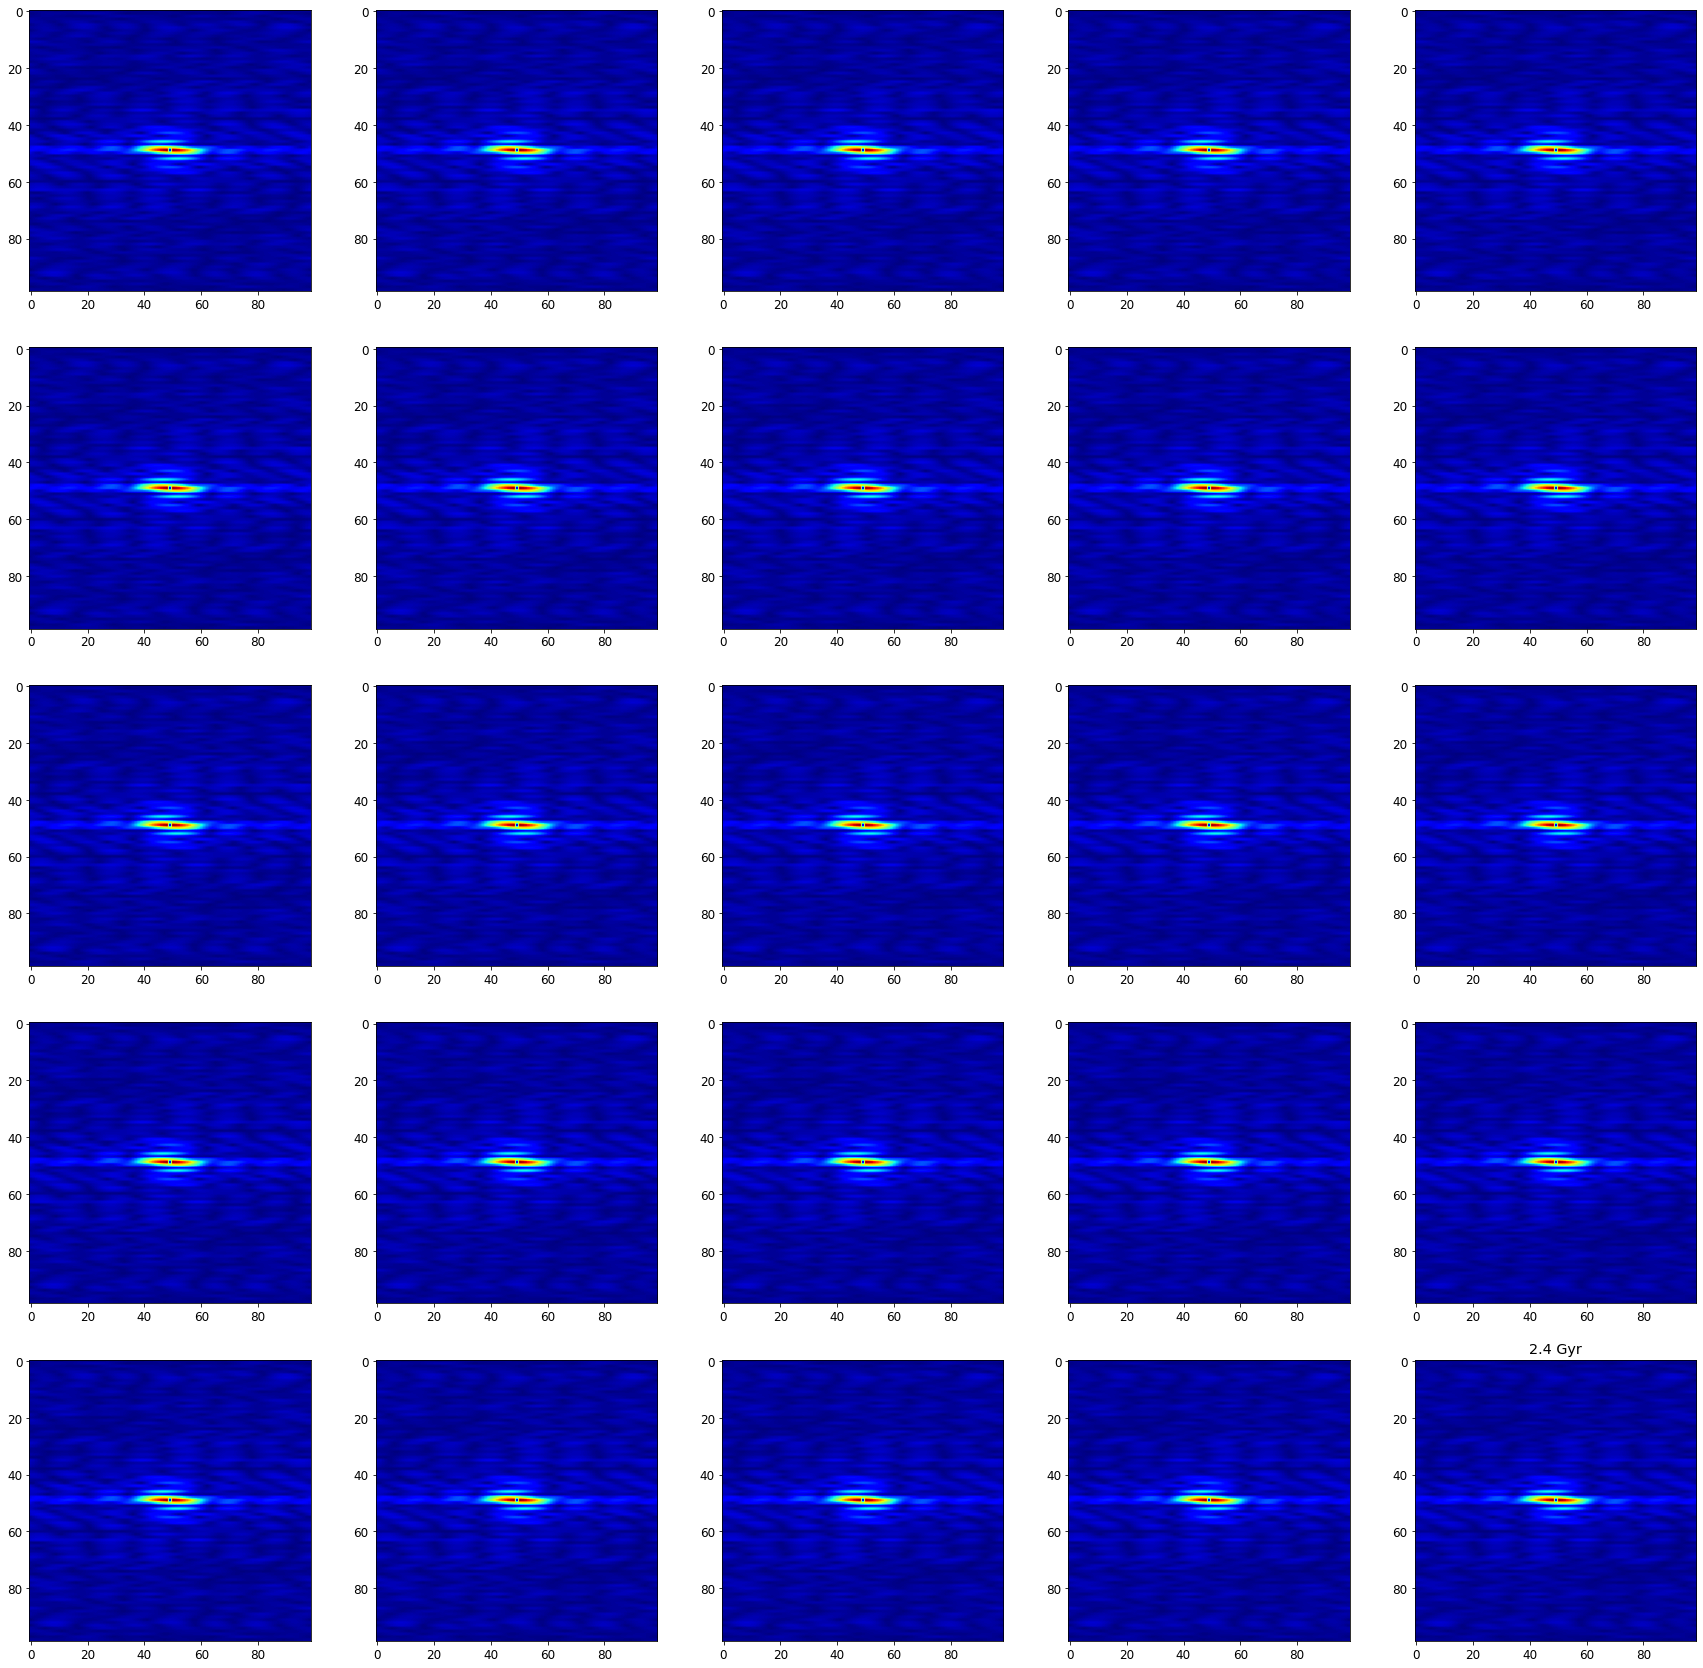

In [445]:

TIME = 1.8
BIAS = -840

def animate(frame, ax=None):
    TIME = frame * 0.1 + 0.001
    plt.title(f"{TIME:.2} Gyr")
   
    XMIN=1200
    XMAX=3500
    x,y,VR,Vphi,R,Lz,phi=l.load_model(CURMODEL, TIME, xmin=XMIN, xmax=XMAX, phi_range=np.pi)

    VRn = VR / Lz
    binsX=np.linspace(np.log10(XMIN+BIAS),np.log10(XMAX+BIAS),100)
    binsY=np.linspace(-np.pi,np.pi,100)
    mVR,xedge,yedge,binnumber=stats.binned_statistic_2d(np.log10(Lz+BIAS), phi, VRn, statistic='mean', bins=[binsX,binsY])    
    #plt.pcolormesh(xedge, yedge, mVR.T, cmap='RdBu',vmin=-10,vmax=10)

    mVR = np.nan_to_num(mVR)
    mVR = (mVR - mVR.mean()) / (mVR.max() - mVR.min())
    #plt.imshow(mVR)
    f = fftshift(fft2(ifftshift(mVR)))
    #col = np.stack([(np.angle(f)+np.pi)/(2*np.pi), abs(f)/abs(f).max(), np.ones(f.shape)], axis=-1)
    #print(col)
    #plt.imshow(matplotlib.colors.hsv_to_rgb(col))
    if ax is None:
        return plt.imshow(abs(f))
    else:
        f[len(f)//2, len(f)//2] = np.mean(f)
        ax.imshow(abs(f), cmap='jet')

from matplotlib.animation import FuncAnimation
import matplotlib.colors

#fig, ax = plt.subplots()
#anim = FuncAnimation(fig, animate, frames=200, interval=20)

fig, ax = plt.subplots(5,5, figsize=(30,30))
for i in range(25):
    animate(i, ax[i//5][i%5])

/home/hpc/anaconda3/lib/python3.9/site-packages/astropy/table/table.py:3488: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other

0.34434517985726343
(45, 49)
(-0.040816326530612235, 0.0)
4.540816326530611 1.5707963267948966


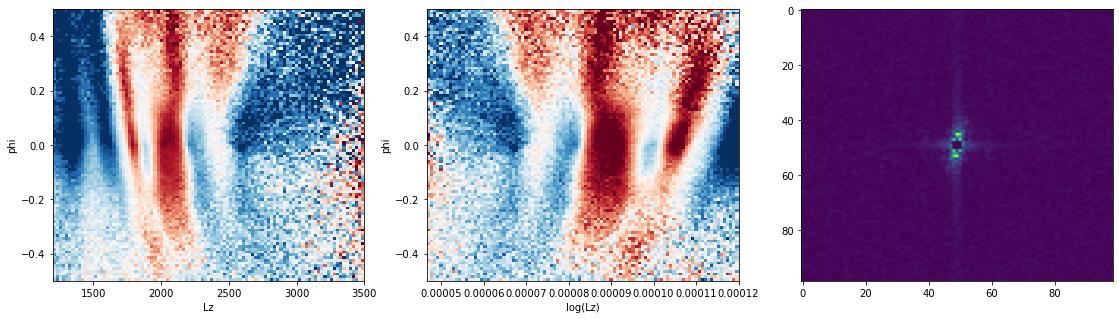

In [8]:
#TIME = 0.8
#XMIN=1200
#XMAX=3500
#x,y,VR,Vphi,R,Lz,phi=l.load_model(CURMODEL, TIME, xmin=XMIN, xmax=XMAX, phi_range=np.pi)

#BIAS = 0
#TIME = 4.5
#XMIN=1000
#XMAX=3500
#BINSIZE = 10
#x,y,VR,Vphi,R,Lz,phi=l.load_model('MW_Sgr', TIME, xmin=XMIN, xmax=XMAX, phi_range=np.pi)
#DATA = False

XMIN=1000
XMAX=3500
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=np.pi, new=True)
DATA = True

fig, ax = plt.subplots(1, 3, figsize=(19,5))

VRn = VR / Lz
n = -0.1
Lzl = Lz ** ((n-1)/(n+1))
#binsX=np.linspace(1200,3500,100)
binsX=np.linspace(Lzl.min(),Lzl.max(),100)
binsY=np.linspace(-np.pi,np.pi,100)
binsY=np.linspace(-0.5,0.5,100)
binsX=np.linspace(Lzl.min(),0.00012,100)
mVR,xedge,yedge,binnumber=stats.binned_statistic_2d(Lz, phi, VR, statistic='mean', bins=[np.linspace(1200,3500,100),binsY])    
ax[0].pcolormesh(xedge, yedge, mVR.T, cmap='RdBu',vmin=-10,vmax=10)
ax[0].set_aspect('auto')
ax[0].set_xlabel('Lz')
ax[0].set_ylabel('phi')
mVR,xedge,yedge,binnumber=stats.binned_statistic_2d(Lzl, phi, VRn, statistic='mean', bins=[binsX,binsY])    
ax[1].pcolormesh(xedge, yedge, mVR.T, cmap='RdBu',vmin=-10/2500,vmax=10/2500)
ax[1].set_aspect('auto')
ax[1].set_xlabel('log(Lz)')
ax[1].set_ylabel('phi')

mVR = np.nan_to_num(mVR)
mVR = (mVR - mVR.mean()) / (mVR.max() - mVR.min())
#plt.imshow(mVR)
#x1, x2 = np.meshgrid(np.linspace(0, 1, 99), np.linspace(0, 1, 99))
#mVR = 2*np.cos(2*x1*2*np.pi+0.9*np.pi)
#ax[1].imshow(mVR)
f = fftshift(fft2(ifftshift(mVR)))
#col = np.stack([(np.angle(f)+np.pi)/(2*np.pi), abs(f)/abs(f).max(), np.ones(f.shape)], axis=-1)
#print(col)
#plt.imshow(matplotlib.colors.hsv_to_rgb(col))
f[len(f)//2, len(f)//2] = np.mean(f)
import itertools
for dx,dy in itertools.product([-1,0,1],[-1,0,1]):
    f[len(f)//2+dx, len(f)//2+dy] = np.mean(f)
#ax[2].imshow(abs(f))
ax[2].imshow(abs(f))
#ax[1].imshow(np.sqrt(abs(f)))
ax[2].set_aspect('auto')

maximum = np.unravel_index(np.argmax(abs(f)), f.shape)
maxval = f[maximum]
print((-np.angle(maxval)%(np.pi))/np.pi)
print(maximum)
maximum = (maximum[0]/(len(f)-1)-0.5, maximum[1]/(len(f)-1)-0.5)
print(maximum)
freq = np.linalg.norm(maximum)*len(f) + 0.5
angle = np.arctan2(*maximum)%np.pi
print(freq, angle)


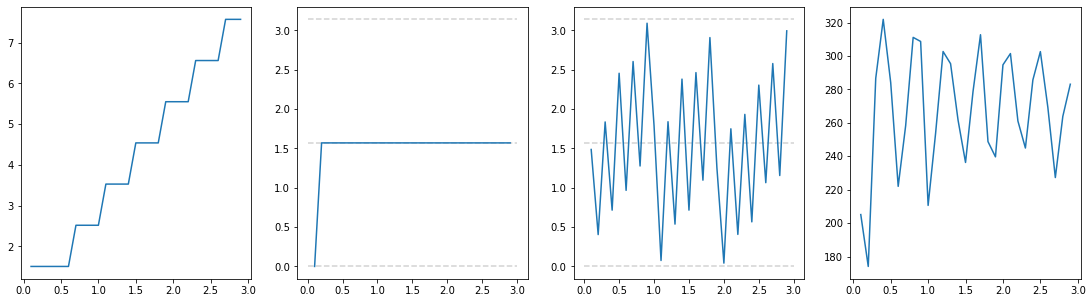

In [16]:
times = np.arange(.1,3.0,.1)
fig, ax = plt.subplots(1, 4, figsize=(19,5))
freqs = []
angles = []
phases = []
amplitudes = []

for time in times:
    XMIN=1200
    XMAX=3500
    x,y,VR,Vphi,R,Lz,phi=l.load_model('Dhotn_10_pn_10', time, xmin=XMIN, xmax=XMAX, phi_range=np.pi)

    Lzl = Lz ** ((n-1)/(n+1))
    VRn = VR / Lz
    #binsX=np.linspace(1200,3500,100)
    #binsX=np.linspace(nx.min(),nx.max(),100)
    #binsY=np.linspace(-np.pi,np.pi,100)
    binsY=np.linspace(-0.5,0.5,100)
    binsX=np.linspace(Lzl.min(),0.00012,100)
    mVR,xedge,yedge,binnumber=stats.binned_statistic_2d(Lzl, phi, VRn, statistic='mean', bins=[binsX,binsY])    

    mVR = np.nan_to_num(mVR)
    mVR = (mVR - mVR.mean()) / (mVR.max() - mVR.min())
    f = fftshift(fft2(ifftshift(mVR)))
    f[len(f)//2, len(f)//2] = np.mean(f)

    
    maximum = np.unravel_index(np.argmax(abs(f)), f.shape)
    maxval = f[maximum]
    phase = (-np.angle(maxval))%(np.pi)
    amplitude = np.abs(maxval)
    maximum = (maximum[0]/(len(f)-1)-0.5, maximum[1]/(len(f)-1)-0.5)
    freq = np.linalg.norm(maximum)*len(f)+0.5
    angle = np.arctan2(*maximum)%np.pi
    freqs.append(freq)
    angles.append(angle)
    phases.append(phase)
    amplitudes.append(amplitude)
    #print(time, freq, angle)

ax[0].plot(times, freqs)
ax[1].hlines([0,np.pi/2,np.pi],0,3,ls='--',color='lightgrey')
ax[1].plot(times, angles)
ax[2].hlines([0,np.pi/2,np.pi],0,3,ls='--',color='lightgrey')
from scipy.signal import hilbert
ax[2].plot(times, phases)
ax[3].plot(times, amplitudes)

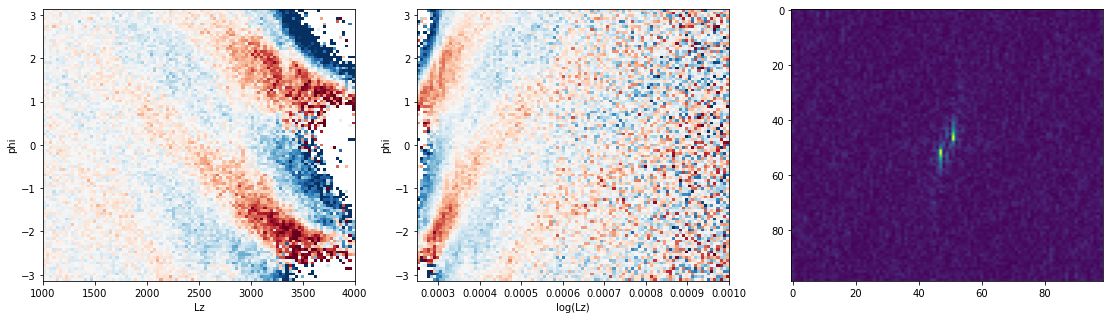

In [4]:
#TIME = 1.5
#BIAS = -840
#XMIN=1200
#XMAX=3500
#x,y,VR,Vphi,R,Lz,phi=l.load_model(CURMODEL, TIME, xmin=XMIN, xmax=XMAX, phi_range=np.pi)

TIME = 2.8
XMIN=1000
XMAX=4000
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_model('MW_Sgr', TIME, xmin=XMIN, xmax=XMAX, phi_range=np.pi)
phi=-phi
DATA = False


fig, ax = plt.subplots(1, 3, figsize=(19,5))

VRn = VR / Lz
#Lzl = np.log10(Lz+BIAS)
Lzl = 1/Lz
#binsX=np.linspace(1200,3500,100)
#binsX=np.linspace(np.log10(XMIN+BIAS),np.log10(XMAX+BIAS),100)
binsX=np.linspace(1/XMAX,1/XMIN,100)
binsY=np.linspace(-np.pi,np.pi,100)
mVR,xedge,yedge,binnumber=stats.binned_statistic_2d(Lz, phi, VR, statistic='mean', bins=[np.linspace(XMIN,XMAX,100),binsY])    
ax[0].pcolormesh(xedge, yedge, mVR.T, cmap='RdBu',vmin=-10,vmax=10)
ax[0].set_aspect('auto')
ax[0].set_xlabel('Lz')
ax[0].set_ylabel('phi')
mVR,xedge,yedge,binnumber=stats.binned_statistic_2d(Lzl, phi, VRn, statistic='mean', bins=[binsX,binsY])    
ax[1].pcolormesh(xedge, yedge, mVR.T, cmap='RdBu',vmin=-10/2500,vmax=10/2500)
ax[1].set_aspect('auto')
ax[1].set_xlabel('log(Lz)')
ax[1].set_ylabel('phi')

mVR = np.nan_to_num(mVR)
mVR = (mVR - mVR.mean()) / (mVR.max() - mVR.min())
#plt.imshow(mVR)
f = fftshift(fft2(ifftshift(mVR)))
#col = np.stack([(np.angle(f)+np.pi)/(2*np.pi), abs(f)/abs(f).max(), np.ones(f.shape)], axis=-1)
#print(col)
#plt.imshow(matplotlib.colors.hsv_to_rgb(col))
f[len(f)//2, len(f)//2] = np.mean(f)
#ax[2].imshow(abs(f))
ax[2].imshow(abs(f))
#ax[1].imshow(np.sqrt(abs(f)))
ax[2].set_aspect('auto')


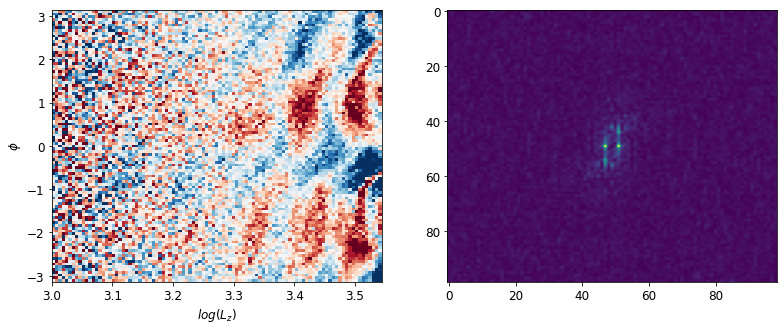

In [885]:

#TIME = 1.5
#BIAS = -840
#XMIN=1200
#XMAX=3500
#x,y,VR,Vphi,R,Lz,phi=l.load_model(CURMODEL, TIME, xmin=XMIN, xmax=XMAX, phi_range=np.pi)

BIAS = 0
TIME = 4.5
XMIN=1000
XMAX=3500
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_model('MW_Sgr', TIME, xmin=XMIN, xmax=XMAX, phi_range=np.pi)
DATA = False


fig, ax = plt.subplots(1, 2, figsize=(13,5))

VRn = VR / Lz
Lzl = np.log10(Lz+BIAS)
#binsX=np.linspace(1200,3500,100)
binsX=np.linspace(np.log10(XMIN+BIAS),np.log10(XMAX+BIAS),100)
binsY=np.linspace(-np.pi,np.pi,100)
mVR,xedge,yedge,binnumber=stats.binned_statistic_2d(Lz, phi, VR, statistic='mean', bins=[np.linspace(1200,3500,100),binsY])    
mVR,xedge,yedge,binnumber=stats.binned_statistic_2d(Lzl, phi, VRn, statistic='mean', bins=[binsX,binsY])    
ax[0].pcolormesh(xedge, yedge, mVR.T, cmap='RdBu',vmin=-5/2500,vmax=5/2500)
ax[0].set_aspect('auto')
ax[0].set_xlabel(r'$log(L_z)$')
ax[0].set_ylabel(r'$\phi$')

mVR = np.nan_to_num(mVR)
mVR = (mVR - mVR.mean()) / (mVR.max() - mVR.min())
#plt.imshow(mVR)
f = fftshift(fft2(ifftshift(mVR)))
#col = np.stack([(np.angle(f)+np.pi)/(2*np.pi), abs(f)/abs(f).max(), np.ones(f.shape)], axis=-1)
#print(col)
#plt.imshow(matplotlib.colors.hsv_to_rgb(col))
f[len(f)//2, len(f)//2] = np.mean(f)
#ax[2].imshow(abs(f))
ax[1].imshow(abs(f))
#ax[1].imshow(np.sqrt(abs(f)))
ax[1].set_aspect('auto')

namef='plots/fourier_2d.png'
plt.savefig(namef, bbox_inches='tight')

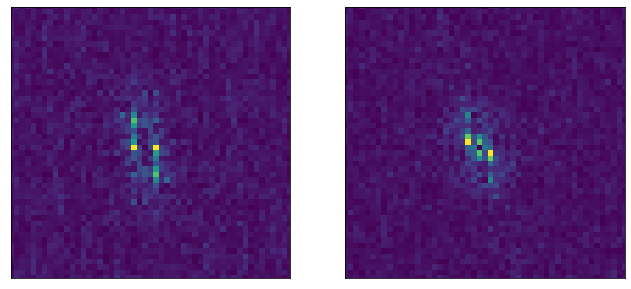

In [12]:
BIAS = 0
TIME = 4.5
XMIN=500
XMAX=3000
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_model('MW_Sgr', TIME, xmin=XMIN, xmax=XMAX, phi_range=np.pi)
DATA = False

fig, ax = plt.subplots(1, 2, figsize=(11,5))

VRn = VR / Lz
#Lzl = 1/Lz
Lzl = Lz
#binsX=np.linspace(1200,3500,100)
binsX=np.linspace(np.min(Lzl), np.max(Lzl), 200)
binsY=np.linspace(-np.pi,np.pi,200)
mVR,xedge,yedge,binnumber=stats.binned_statistic_2d(Lz, phi, VR, statistic='mean', bins=[np.linspace(1200,3500,100),binsY])    
mVR,xedge,yedge,binnumber=stats.binned_statistic_2d(Lzl, phi, VRn, statistic='mean', bins=[binsX,binsY])    
#ax[0].pcolormesh(xedge, yedge, mVR.T, cmap='RdBu',vmin=-10/2500,vmax=10/2500)
#ax[0].set_aspect('auto')
#ax[0].set_xlabel(r'$log(L_z)$')
#ax[0].set_ylabel(r'$\phi$')

mVR = np.nan_to_num(mVR)
mVR = (mVR - mVR.mean()) / (mVR.max() - mVR.min())
#plt.imshow(mVR)
f = fftshift(fft2(ifftshift(mVR)))
#col = np.stack([(np.angle(f)+np.pi)/(2*np.pi), abs(f)/abs(f).max(), np.ones(f.shape)], axis=-1)
#print(col)
#plt.imshow(matplotlib.colors.hsv_to_rgb(col))
f[len(f)//2, len(f)//2] = np.mean(f)
#ax[2].imshow(abs(f))
ax[0].imshow(abs(f), cmap='viridis')
#ax[1].imshow(np.sqrt(abs(f)))
ax[0].set_aspect('auto')
ax[0].set_xlim(75,125)
ax[0].set_ylim(75,125)
ax[0].xaxis.set_ticks([])
ax[0].yaxis.set_ticks([])


BIAS = 0
TIME = 4.8
XMIN=500
XMAX=3000
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_model('MW_Sgr', TIME, xmin=XMIN, xmax=XMAX, phi_range=np.pi)
DATA = False

VRn = VR / Lz
#Lzl = 1/Lz
Lzl = Lz
#binsX=np.linspace(1200,3500,100)
binsX=np.linspace(np.min(Lzl), np.max(Lzl), 200)
binsY=np.linspace(-np.pi,np.pi,200)
mVR,xedge,yedge,binnumber=stats.binned_statistic_2d(Lz, phi, VR, statistic='mean', bins=[np.linspace(1200,3500,100),binsY])    
mVR,xedge,yedge,binnumber=stats.binned_statistic_2d(Lzl, phi, VRn, statistic='mean', bins=[binsX,binsY])    
#ax[0].pcolormesh(xedge, yedge, mVR.T, cmap='RdBu',vmin=-10/2500,vmax=10/2500)
#ax[0].set_aspect('auto')
#ax[0].set_xlabel(r'$log(L_z)$')
#ax[0].set_ylabel(r'$\phi$')

mVR = np.nan_to_num(mVR)
mVR = (mVR - mVR.mean()) / (mVR.max() - mVR.min())
#plt.imshow(mVR)
f = fftshift(fft2(ifftshift(mVR)))
#col = np.stack([(np.angle(f)+np.pi)/(2*np.pi), abs(f)/abs(f).max(), np.ones(f.shape)], axis=-1)
#print(col)
#plt.imshow(matplotlib.colors.hsv_to_rgb(col))
f[len(f)//2, len(f)//2] = np.mean(f)
#ax[2].imshow(abs(f))
ax[1].imshow(abs(f), cmap='viridis')
#ax[1].imshow(np.sqrt(abs(f)))
ax[1].set_aspect('auto')
ax[1].set_xlim(75,125)
ax[1].set_ylim(75,125)
ax[1].xaxis.set_ticks([])
ax[1].yaxis.set_ticks([])

namef='plots/fourier_2d.png'
plt.savefig(namef, bbox_inches='tight')

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3000000000000003
1.4000000000000001
1.5000000000000002
1.6
1.7000000000000002
1.8000000000000003
1.9000000000000001
2.0
2.1
2.2
2.3000000000000003
2.4000000000000004
2.5000000000000004
2.6
2.7
2.8000000000000003
2.9000000000000004
3.0000000000000004
3.1
3.2
3.3000000000000003
3.4000000000000004
3.5000000000000004
3.6
3.7
3.8000000000000003
3.9000000000000004
4.0
4.1
4.2
4.3
4.3999999999999995
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9


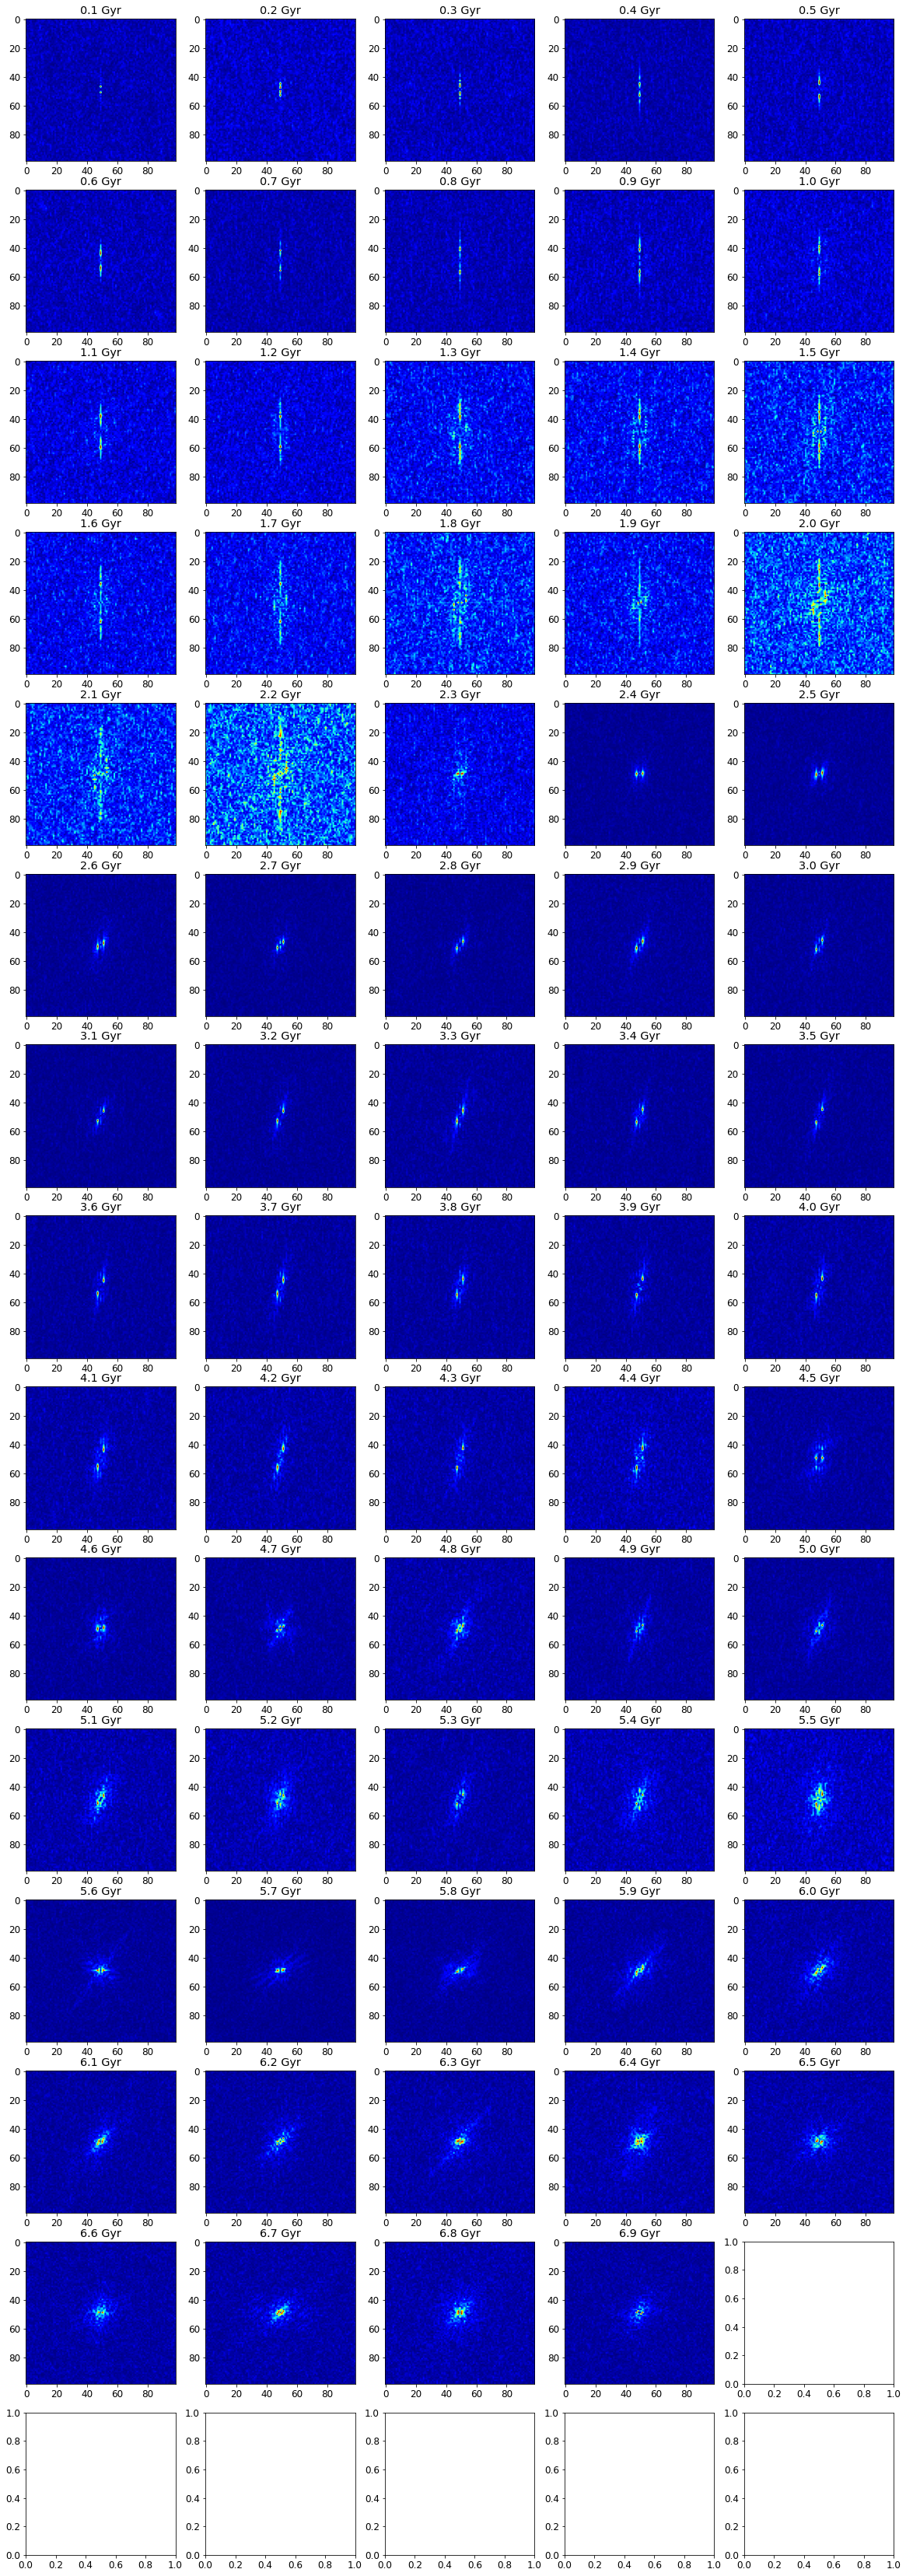

In [459]:
BIAS = 0

times = np.arange(0.1,7.0,0.1)
fig, ax = plt.subplots(15, 5, figsize=(20,60))

for timei, TIME in enumerate(times):
    print(TIME)
    XMIN=1000
    XMAX=4000
    BINSIZE = 10
    x,y,VR,Vphi,R,Lz,phi=l.load_model('MW_Sgr', TIME, xmin=XMIN, xmax=XMAX, phi_range=np.pi)
    DATA = False

    VRn = VR / Lz
    Lzl = np.log10(Lz+BIAS)
    #binsX=np.linspace(1200,3500,100)
    binsX=np.linspace(np.log10(XMIN+BIAS),np.log10(XMAX+BIAS),100)
    binsY=np.linspace(-np.pi,np.pi,100)
    mVR,xedge,yedge,binnumber=stats.binned_statistic_2d(Lz, phi, VR, statistic='mean', bins=[np.linspace(1200,3500,100),binsY])    
    mVR,xedge,yedge,binnumber=stats.binned_statistic_2d(Lzl, phi, VRn, statistic='mean', bins=[binsX,binsY])    

    mVR = np.nan_to_num(mVR)
    mVR = (mVR - mVR.mean()) / (mVR.max() - mVR.min())
    #plt.imshow(mVR)
    f = fftshift(fft2(ifftshift(mVR)))
    #col = np.stack([(np.angle(f)+np.pi)/(2*np.pi), abs(f)/abs(f).max(), np.ones(f.shape)], axis=-1)
    #print(col)
    #plt.imshow(matplotlib.colors.hsv_to_rgb(col))
    f[len(f)//2, len(f)//2] = np.mean(f)
    cax = ax[timei//5][timei%5]
    cax.imshow(abs(f), cmap='jet')
    cax.set_aspect('auto')
    cax.set_title(f'{TIME:.2} Gyr')

Text(0, 0.5, 'phi')

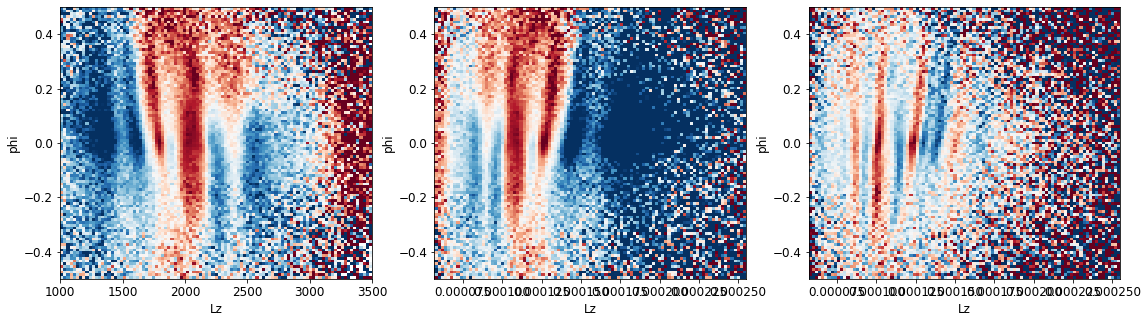

In [566]:
XMIN=1000
XMAX=3500
BINSIZE = 50
BIAS=0
PHI_RANGE = 0.2
PHI_RANGE = 0.5
x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=PHI_RANGE)

fig, ax = plt.subplots(1, 3, figsize=(19,5))

VRn = VR / Lz
#Lzl = np.log10(Lz+BIAS)
n = -0.09
Lzl = (1/Lz)**((1-n)/(1+n))
#binsX=np.linspace(1200,3500,100)
#binsX=np.linspace(np.log10(XMIN+BIAS),np.log10(XMAX+BIAS),100)
binsX=np.linspace(1/XMIN,1/XMAX,100)
binsY=np.linspace(-PHI_RANGE,PHI_RANGE,100)
mVR,xedge,yedge,binnumber=stats.binned_statistic_2d(Lz, phi, VR, statistic='mean', bins=[np.linspace(XMIN,XMAX,100),binsY])    
ax[0].pcolormesh(xedge, yedge, mVR.T, cmap='RdBu',vmin=-10,vmax=10)
ax[0].set_aspect('auto')
ax[0].set_xlabel('Lz')
ax[0].set_ylabel('phi')
mVR,xedge,yedge,binnumber=stats.binned_statistic_2d(Lzl, phi, VR/Lz, statistic='mean', bins=[np.linspace((1/XMAX)**((1-n)/(1+n)),(1/XMIN)**((1-n)/(1+n)),100),binsY])    
ax[1].pcolormesh(xedge, yedge, mVR.T, cmap='RdBu',vmin=-10/2000,vmax=10/2000)
ax[1].set_aspect('auto')
ax[1].set_xlabel('Lz')
ax[1].set_ylabel('phi')
mVR = np.gradient(mVR, axis=0)
ax[2].pcolormesh(xedge, yedge, mVR.T, cmap='RdBu',vmin=-10/4000,vmax=10/4000)
ax[2].set_aspect('auto')
ax[2].set_xlabel('Lz')
ax[2].set_ylabel('phi')

#mVR = np.nan_to_num(mVR)
#mVR = (mVR - mVR.mean()) / (mVR.max() - mVR.min())
##plt.imshow(mVR)
#f = fftshift(fft2(ifftshift(mVR)))
##col = np.stack([(np.angle(f)+np.pi)/(2*np.pi), abs(f)/abs(f).max(), np.ones(f.shape)], axis=-1)
##print(col)
##plt.imshow(matplotlib.colors.hsv_to_rgb(col))
#f[len(f)//2, len(f)//2] = np.mean(f)
##ax[2].imshow(abs(f))
#ax[2].imshow(abs(f))
##ax[1].imshow(np.sqrt(abs(f)))
#ax[2].set_aspect('auto')

In [58]:
VR,Vphi,VZ,x,y,Z,R,phi=np.array((oo['VR'],oo['Vphi'],oo['VZ'],oo['X'],oo['Y'],oo['Z'],oo['R'],oo['phi']))
Lz=-oo['Vphi']*oo['R']
phi=-np.deg2rad(phi)
Vphi=-Vphi

PHI_RANGE = 0.2
indphi = abs(phi) < PHI_RANGE
x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]

fig, ax = plt.subplots(1, 3, figsize=(19,5))

VRn = VR / Lz
BIAS = -800
Lzl = np.log10(Lz+BIAS)
#binsX=np.linspace(1200,3500,100)
binsX=np.linspace(np.log10(1500+BIAS),np.log10(3000+BIAS),100)
binsY=np.linspace(-PHI_RANGE,PHI_RANGE,100)
mVR,xedge,yedge,binnumber=stats.binned_statistic_2d(Lz, phi, VR, statistic='mean', bins=[np.linspace(1000,3000,100),binsY])    
ax[0].pcolormesh(xedge, yedge, mVR.T, cmap='RdBu',vmin=-10,vmax=10)
ax[0].set_aspect('auto')
ax[0].set_xlabel('Lz')
ax[0].set_ylabel('phi')
mVR,xedge,yedge,binnumber=stats.binned_statistic_2d(Lzl, phi, VRn, statistic='mean', bins=[binsX,binsY])    
ax[1].pcolormesh(xedge, yedge, mVR.T, cmap='RdBu',vmin=-10/2500,vmax=10/2500)
ax[1].set_aspect('auto')
ax[1].set_xlabel('log(Lz)')
ax[1].set_ylabel('phi')

mVR = np.nan_to_num(mVR)
mVR = (mVR - mVR.mean()) / (mVR.max() - mVR.min())
#plt.imshow(mVR)
f = fftshift(fft2(ifftshift(mVR)))
#col = np.stack([(np.angle(f)+np.pi)/(2*np.pi), abs(f)/abs(f).max(), np.ones(f.shape)], axis=-1)
#print(col)
#plt.imshow(matplotlib.colors.hsv_to_rgb(col))
f[len(f)//2, len(f)//2] = np.mean(f)
ax[2].imshow(abs(f))
#ax[2].imshow(np.log10(abs(f)))
ax[2].set_aspect('auto')

NameError: name 'oo' is not defined

['R', 'vrot', 'stdev']
['7.289', '240.1', '4.1']
['8.018', '239.0', '4.4']
['8.82', '236.7', '5.4']


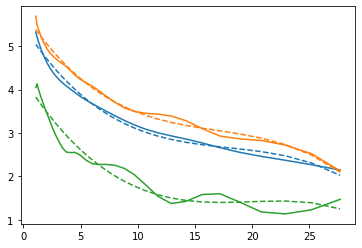

In [369]:
import csv

R = []
vrot = []
vrotmax = []
vrotmin = []
with open('vrot_sofue.csv') as f:
    reader = csv.reader(f)
    print(next(reader))
    for l in reader:
        if float(l[0]) < 1 or float(l[0]) > 30:
            continue
        if 7 < float(l[0]) < 9:
            print(l)
        R.append(float(l[0]))
        vrot.append(float(l[1]))
        vrotmax.append(float(l[1]) + float(l[2]))
        vrotmin.append(float(l[1]) - float(l[2]))
R, vr, vrotmax, vrotmin = (np.array(i) for i in (R, vrot, vrotmax, vrotmin))
        

#plt.plot(R, vr)

w = vr/R
plt.plot(R, np.log(w))
pol = np.poly1d(np.polyfit(R, np.log(w), 3))
plt.plot(R, pol(R), ls='--', c='C0')

dR = np.gradient(R)
dw2 = np.gradient(w**2)
k = np.sqrt(R * dw2/dR + 4 * w**2)
plt.plot(R, np.log(k))
pol2 = np.poly1d(np.polyfit(R, np.log(k), 3))
plt.plot(R, pol2(R), ls='--', c='C1')
freq = w - k/2
plt.plot(R, np.log(freq))
#pol = np.poly1d(np.polyfit(R, np.log(freq), 3))
ffreq = np.exp(pol(R)) - np.exp(pol2(R))/2
plt.plot(R, np.log(ffreq), ls='--', c='C2')

#plt.xlim(0.1,15)
#plt.ylim(0,500)

rfreq = R


['R', 'vrot', 'stdev']
['7.289', '240.1', '4.1']
['8.018', '239.0', '4.4']
['8.82', '236.7', '5.4']


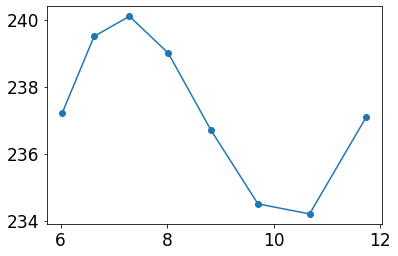

In [54]:
import csv

R = []
vrot = []
vrotmax = []
vrotmin = []
with open('vrot_sofue.csv') as f:
    reader = csv.reader(f)
    print(next(reader))
    for line in reader:
        if float(line[0]) < 5.5 or float(line[0]) > 12:
            continue
        if 7 < float(line[0]) < 9:
            print(line)
        R.append(float(line[0]))
        vrot.append(float(line[1]))
        vrotmax.append(float(line[1]) + float(line[2]))
        vrotmin.append(float(line[1]) - float(line[2]))
R, vr, vrotmax, vrotmin = (np.array(i) for i in (R, vrot, vrotmax, vrotmin))
rr = R

import astropy.units as u
ft=(1*u.km/u.second/u.kpc).to(1./u.Gyr).value

plt.plot(R,vr)
plt.scatter(R,vr)

def plot_segmented(rs, phi, c='C0'):
    nphi = (phi+np.pi)%(2*np.pi)-np.pi
    breaks = [0]
    for i in range(len(nphi)-1):
        if nphi[i] < nphi[i+1] and nphi[i] < 0 and nphi[i+1] > 0:
            breaks.append(i+1)
    breaks.append(len(rs))
    for ll, ul in zip(breaks[:-1], breaks[1:]):
        plt.plot(rs[ll:ul], nphi[ll:ul],c=c)

/home/hpc/anaconda3/lib/python3.9/site-packages/astropy/table/table.py:3488: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other

[ 11  50  79 102 140]
[ 2.4119859  -4.63938448]


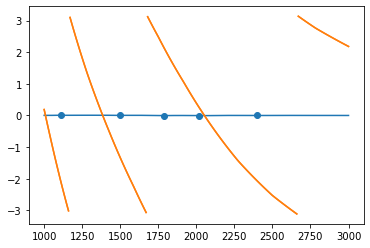

In [410]:
XMIN=1000
XMAX=3000
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2)
DATA = True

nx, ny = smooth_bins(Lz, VR/Lz, XMIN, XMAX, BINSIZE)
N = 100000
P = 1
f = interpolate.interp1d(nx, ny, kind='linear')
xpol = np.linspace(nx[0], nx[-1], N)
ypol = f(xpol)
xpol = xpol[~np.isnan(ypol)]
ypol = ypol[~np.isnan(ypol)]
N = len(ypol)

plt.plot(nx,ny)

from scipy.signal import find_peaks
peaks, _ = find_peaks(-ny, prominence=1e-3, distance=10)
print(peaks)
plt.scatter(nx[peaks], ny[peaks])

#evenpeaks = peaks[::2]
#oddpeaks = peaks[1::2]
#plt.plot(nx[evenpeaks], 2*np.pi*np.arange(1, len(evenpeaks)+1))
#plt.plot(nx[oddpeaks], 2*np.pi*np.arange(1, len(oddpeaks)+1))


def an_R(phi, t, n):
    V0 = 240
    R0 = 8
    phi0 = 0
    pn = 1 - 0.5*np.sqrt(2**(n+1))
    return V0/(R0**n) * ((pn*t)/(phi-phi0))**(1/(1-n))

def an_phi(R, t, n, V0=240, phi0=0):
    #V0 = 240
    R0 = 8
    pn = 1 - 0.5*np.sqrt(2**(n+1))
    return phi0 + pn * t * (R * R0**n / V0)**(n-1)

LzR = rr*vr
rfromlz = interpolate.interp1d(LzR, rr)

def an_phi_mod(Lz, t, n, phi0):
    r = rfromlz(Lz)
    return an_phi(r,t,n,phi0=phi0)

fun = lambda Lz, t, phi0: an_phi_mod(Lz, t, optn, phi0)
optpar = optimize.curve_fit(fun, nx[peaks], np.pi*np.arange(len(peaks)+1,1,-1))[0]
#optpar = optimize.curve_fit(fun, nx[peaks], np.pi*np.arange(len(peaks)+1,1,-1),bounds=([0,-np.inf],[np.inf,np.inf]))[0]
#fun = lambda Lz, t, phi0, n: an_phi_mod(Lz, t, n, phi0)
#optpar = optimize.curve_fit(fun, nx[peaks], np.pi*np.arange(len(peaks)+1,1,-1),bounds=([0.0,-0.2,-np.inf],[5.0,0.2,np.inf]))[0]
#optpar = optimize.curve_fit(fun, nx[peaks], np.pi*np.arange(len(peaks)+1,1,-1))[0]
print(optpar)
#plt.plot(nx, fun(nx, *optpar))
#plt.plot(nx, an_phi(nx,1,0))
optpar2 = optpar
optpar2[1] += np.pi
plot_segmented(nx, fun(nx, *optpar), c='C1')
plot_segmented(nx, fun(nx, *optpar2), c='C1')

/home/hpc/anaconda3/lib/python3.9/site-packages/astropy/table/table.py:3488: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other

[  2.31972433 -10.13039902]


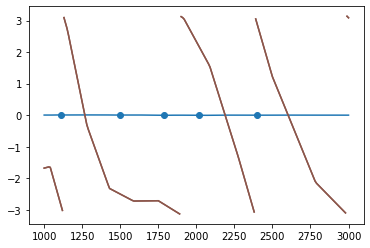

In [411]:

XMIN=1000
XMAX=3000
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2)
DATA = True

nx, ny = smooth_bins(Lz, VR/Lz, XMIN, XMAX, BINSIZE)
N = 100000
P = 1
f = interpolate.interp1d(nx, ny, kind='linear')
xpol = np.linspace(nx[0], nx[-1], N)
ypol = f(xpol)
xpol = xpol[~np.isnan(ypol)]
ypol = ypol[~np.isnan(ypol)]
N = len(ypol)

plt.plot(nx,ny)

from scipy.signal import find_peaks
peaks, _ = find_peaks(-ny, prominence=1e-3, distance=10)
plt.scatter(nx[peaks], ny[peaks])

evenpeaks = peaks[::2]
oddpeaks = peaks[1::2]
#plt.plot(nx[evenpeaks], 2*np.pi*np.arange(1, len(evenpeaks)+1))
#plt.plot(nx[oddpeaks], 2*np.pi*np.arange(1, len(oddpeaks)+1))


#vcs_interp = np.poly1d(np.polyfit(rr, vr, 15))
#vcs_interp = interpolate.interp1d(R, vr, 'quadratic')
#plt.plot(rr, vcs_interp(rr), ls='--', c='C0')


w = vr/rr
dR = np.gradient(rr)
dw2 = np.gradient(w**2)
k = np.sqrt(rr * dw2/dR + 4 * w**2)
freq = ft*(w - k/2)
#plt.plot(rr, freq)
ffreq = interpolate.interp1d(rr, freq, 'linear')
def phiR(R, t, phi0=0):
    return phi0 + ffreq(R)*t

#rr = np.arange(2,25,0.5)
#n = -0.1
#vr = V0 * (rr/R0)**n
#w = vr/rr
#dR = np.gradient(rr)
#dw2 = np.gradient(w**2)
#k = np.sqrt(rr * dw2/dR + 4 * w**2)
#freq = ft*(w - k/2)

#rr = np.arange(3,25,0.5)
#n = 0.04
#vr = V0 * (rr/R0)**n
#w = vr/rr
#dR = np.gradient(rr)
#dw2 = np.gradient(w**2)
#k = np.sqrt(rr * dw2/dR + 4 * w**2)
#freq = ft*(w - k/2)

#rs = np.linspace(4,18,100)
#vcs = vcs_interp(rs)
#w = vcs/rs
##plt.plot(rs, w)
#dR = np.gradient(rs)
#dw2 = np.gradient(w**2)
#k = np.sqrt(rs * dw2/dR + 4 * w**2)
##plt.plot(rs, k)
#freq = w - k/2
##plt.plot(rs, freq)
#ffreq = interpolate.interp1d(rs, freq, 'linear')
#def phiR(R, t, phi0=0):
#    return phi0 + ffreq(R)*t

#plt.plot(np.arange(4,18,0.1), ffreq(np.arange(4,18,0.1)))
#plot_segmented(np.arange(4,18,0.1), phiR(np.arange(4,18,0.1), 2))

LzR = rr*vr
rfromlz = interpolate.interp1d(LzR, rr)

def phiR_mod(Lz, t, phi0):
    r = rfromlz(Lz)
    return phiR(r,t,phi0=phi0)

optpar = optimize.curve_fit(phiR_mod, nx[peaks], np.pi*np.arange(len(peaks)+1,1,-1),bounds=([0,-np.inf],[np.inf,np.inf]))[0]
print(optpar)
optpar2 = optpar
optpar2[1] += np.pi
plot_segmented(nx, phiR_mod(nx, *optpar), c=f'C{i+1}')
plot_segmented(nx, phiR_mod(nx, *optpar2), c=f'C{i+1}')
#for i, time in enumerate(np.arange(1,4,1)):
#    optpar = [time,-10]
#    optpar2 = optpar
#    optpar2[1] += np.pi
#    plot_segmented(nx, phiR_mod(nx, *optpar), c=f'C{i+1}')
#    plot_segmented(nx, phiR_mod(nx, *optpar2), c=f'C{i+1}')
#    #plt.plot(nx, fun(nx,*optpar), c=f'C{i+1}')

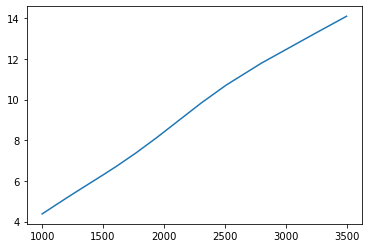

In [82]:

LzR = rr*vr
rfromlz = interpolate.interp1d(LzR, rr)
plt.plot(np.arange(1000,3500,1), rfromlz(np.arange(1000,3500,1)))

[0.00885839 0.09504666]


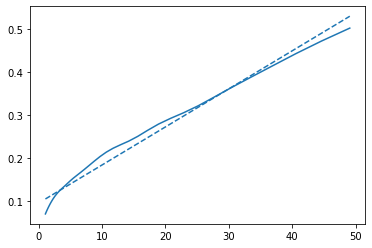

In [5]:

import csv

R = []
vrot = []
vrotmax = []
vrotmin = []
with open('vrot_sofue.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for l in reader:
        if float(l[0]) < 1 or float(l[0]) > 50:
            continue
        R.append(float(l[0]))
        vrot.append(float(l[1]))
        vrotmax.append(float(l[1]) + float(l[2]))
        vrotmin.append(float(l[1]) - float(l[2]))
R, vr, vrotmax, vrotmin = (np.array(i) for i in (R, vrot, vrotmax, vrotmin))
        

#plt.plot(R, vr)

w = np.sqrt(vr/R)
plt.plot(R, 1/w)
coeff = np.polyfit(R, 1/w, 1)
print(coeff)
pol = np.poly1d(coeff)
plt.plot(R, pol(R), ls='--', c='C0')

dR = np.gradient(R)
dw2 = np.gradient(w**2)
k = np.sqrt(R * dw2/dR + 4 * w**2)
#pol2 = np.poly1d(np.polyfit(R, 1/k, 8))
#def pol2g(R, c0, c1):
#    return R * (-2)*c1*(c1*R+c0)**(-3) + 4 / (c1*R+c0)**2
#def pol2g(R, c0, c1):
#    return R * (-2)*c1 / (c1*R+c0)**3 + 4 / (c1*R+c0)**2
#coeff2 = optimize.curve_fit(pol2g, R, k**2)[0]
#print(coeff2)
#pol2 = lambda R: np.sqrt(pol2g(R, coeff2[0], coeff2[1]))
#plt.plot(R, pol2(R), ls='--', c='C1')
#plt.plot(R, k)
#freq = w - k/2
#plt.plot(R, freq)
#ffreq = 1/pol(R) - (pol2(R))/2
#def freqR(R):
#    return 1/pol(R) - pol2(R)/2
#plt.plot(R, ffreq, ls='--', c='C2')
#print(R)
#print(ffreq)
#
#plt.xlim(0.1,15)
##plt.ylim(0,500)
#
rfreq = R

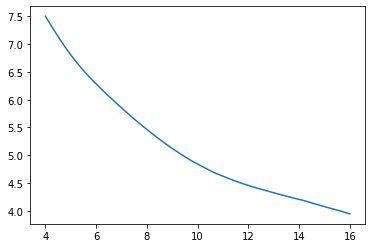

In [6]:
rs = np.linspace(4,16,100)
vcs_interp = interpolate.interp1d(rfreq, vr, 'linear')
vcs = vcs_interp(rs)
plt.plot(rs, np.sqrt(vcs/rs))

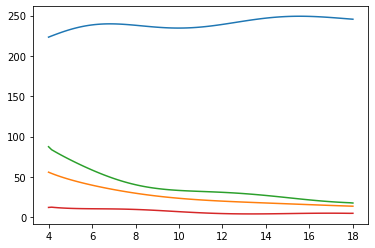

In [19]:
#plt.plot(R, vr)
#plt.scatter(R, vr)
vcs_interp = np.poly1d(np.polyfit(R, vr, 15))
#vcs_interp = interpolate.interp1d(R, vr, 'quadratic')
#plt.plot(R, vcs_interp(R), ls='--', c='C0')

rs = np.linspace(4,18,100)
vcs = vcs_interp(rs)
plt.plot(rs,vcs)
w = vcs/rs
plt.plot(rs, w)
dR = np.gradient(rs)
dw2 = np.gradient(w**2)
k = np.sqrt(rs * dw2/dR + 4 * w**2)
plt.plot(rs, k)
freq = w - k/2
plt.plot(rs, freq)
ffreq = interpolate.interp1d(rs, freq, 'linear')
def phiR(R, t):
    return ffreq(R)*t
#plt.plot(rs, phiR(rs, 0.5))

xl = []
yl = []
xl2 = []
yl2 = []
t = .7
for r in rs:
    xl.append(r*np.sin(phiR(r,t)))
    yl.append(r*np.cos(phiR(r,t)))
    xl2.append(r*np.sin(phiR(r,t)+np.pi))
    yl2.append(r*np.cos(phiR(r,t)+np.pi))
#plt.plot(xl,yl)
#plt.plot(xl2,yl2)
#plt.axis('square')
#plt.xlim(-20,20)
#plt.ylim(-20,20)

#XMIN=1000
#XMAX=3000
#BINSIZE = 10
#x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2)
#DATA = True

/tmp/ipykernel_4655/1122758272.py:16: RuntimeWarning: overflow encountered in power
  return phi0 + pn * t * (R * R0**n / V0)**(n-1)

0.019261646738759162


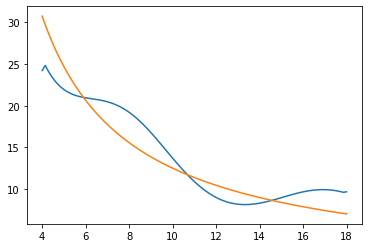

In [372]:
T = 2.0
plt.plot(rs, phiR(rs, T))

def an_R(phi, t, n):
    V0 = 240
    R0 = 8
    phi0 = 0
    pn = 1 - 0.5*np.sqrt(2**(n+1))
    return V0/(R0**n) * ((pn*t)/(phi-phi0))**(1/(1-n))

def an_phi(R, t, n, V0=240):
    #V0 = 240
    R0 = 8
    phi0 = 0
    pn = 1 - 0.5*np.sqrt(2**(n+1))
    return phi0 + pn * t * (R * R0**n / V0)**(n-1)

#lsphi = np.linspace(3,10,100)
#plt.plot(an_R(lsphi, 0.8, 0.01), lsphi)
#plt.plot(rs, an_phi(rs, T, 0))

ofn = lambda r, n: an_phi(r,T,n)
optn = optimize.curve_fit(ofn, rs, phiR(rs,T))[0][0]
print(optn)
plt.plot(rs, an_phi(rs, T, optn))

/tmp/ipykernel_4655/1122758272.py:16: RuntimeWarning: overflow encountered in power
  return phi0 + pn * t * (R * R0**n / V0)**(n-1)



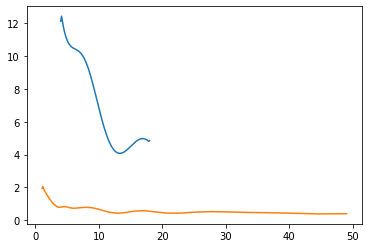

In [385]:
optn = optimize.curve_fit(ofn, rs, phiR(rs,T))[0][0]
plt.plot(rs, ffreq(rs))
plt.plot(rfreq, w-k/2)

(-20.0, 20.0)

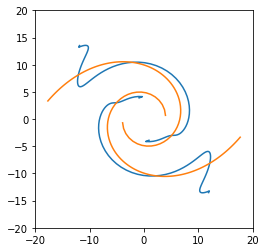

In [373]:

xl = []
yl = []
xl2 = []
yl2 = []
t = .5
for r in rs:
    xl.append(r*np.sin(phiR(r,t)))
    yl.append(r*np.cos(phiR(r,t)))
    xl2.append(r*np.sin(phiR(r,t)+np.pi))
    yl2.append(r*np.cos(phiR(r,t)+np.pi))
plt.plot(xl,yl,c='C0')
plt.plot(xl2,yl2,c='C0')
plt.axis('square')
plt.xlim(-20,20)
plt.ylim(-20,20)

xl = []
yl = []
xl2 = []
yl2 = []
for r in rs:
    ph = an_phi(r,t,optn)
    xl.append(r*np.sin(ph))
    yl.append(r*np.cos(ph))
    xl2.append(r*np.sin(ph+np.pi))
    yl2.append(r*np.cos(ph+np.pi))
plt.plot(xl,yl,c='C1')
plt.plot(xl2,yl2,c='C1')
plt.axis('square')
plt.xlim(-20,20)
plt.ylim(-20,20)

In [9]:
T = 1.6
PHI0 = 0
rs = np.linspace(4,18,200)
vcs = vcs_interp(rs)
        
#plt.plot(rs, nphi)
plot_segmented(rs*vcs, phiR(rs, T)+PHI0, c='C0')
plot_segmented(rs*vcs, phiR(rs, T)+PHI0+np.pi, c='C0')
plot_segmented(rs*vcs, an_phi(rs, T, optn)+PHI0, c='C1')
plot_segmented(rs*vcs, an_phi(rs, T, optn)+PHI0+np.pi, c='C1')
plt.ylim(-np.pi, np.pi)

NameError: name 'vcs_interp' is not defined

(-3.141592653589793, 3.141592653589793)

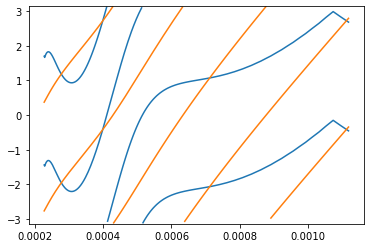

In [380]:

T = 1.0
PHI0 = 0
rs = np.linspace(4,18,200)
vcs = vcs_interp(rs)
def plot_segmented(rs, phi, c='C0'):
    nphi = (phi+np.pi)%(2*np.pi)-np.pi
    breaks = [0]
    for i in range(len(nphi)-1):
        if nphi[i] < nphi[i+1] and nphi[i] < 0 and nphi[i+1] > 0:
            breaks.append(i+1)
    breaks.append(len(rs))
    for ll, ul in zip(breaks[:-1], breaks[1:]):
        plt.plot(rs[ll:ul], nphi[ll:ul],c=c)
        
#plt.plot(rs, nphi)
plot_segmented(1/(rs*vcs), phiR(rs, T)+PHI0, c='C0')
plot_segmented(1/(rs*vcs), phiR(rs, T)+PHI0+np.pi, c='C0')
plot_segmented(1/(rs*vcs), an_phi(rs, T, optn)+PHI0, c='C1')
plot_segmented(1/(rs*vcs), an_phi(rs, T, optn)+PHI0+np.pi, c='C1')
plt.ylim(-np.pi, np.pi)

/tmp/ipykernel_4655/2487271385.py:4: RuntimeWarning: divide by zero encountered in true_divide
  wef = (nx[-1]-nx[0])/(wef*N)



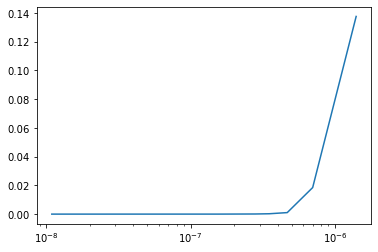

In [487]:
import scipy.signal

wef, wea = scipy.signal.welch(ypol)
wef = (nx[-1]-nx[0])/(wef*N)
#wef = wef * N
plt.plot(wef, wea)
plt.xscale('log')
#plt.xlim(0,0.1)

/home/hpc/anaconda3/lib/python3.9/site-packages/astropy/table/table.py:3488: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other

0.00059945
[9.9950e-05 1.9985e-04 2.9975e-04 3.9965e-04 4.9955e-04 5.9945e-04
 6.9935e-04 7.9925e-04 8.9915e-04 9.9905e-04]
[0.00014133 0.00024476 0.00034611 0.00044682 0.00054723 0.00064748
 0.00074763 0.00084773 0.00094778 0.00104781]
-1.2222222222222223
7073.451327433649
[ 1769.02654867  3537.16814159  5305.30973451  7073.45132743
  8841.59292035 10609.73451327 12377.87610619 14146.01769912
 15914.15929204 17682.30088496]
[ 2501.46843866  4331.94789606  6125.91627302  7908.26006016
  9685.39898814 11459.75476722 13232.44703279 15004.06541614
 16774.95016186 18545.31143549]


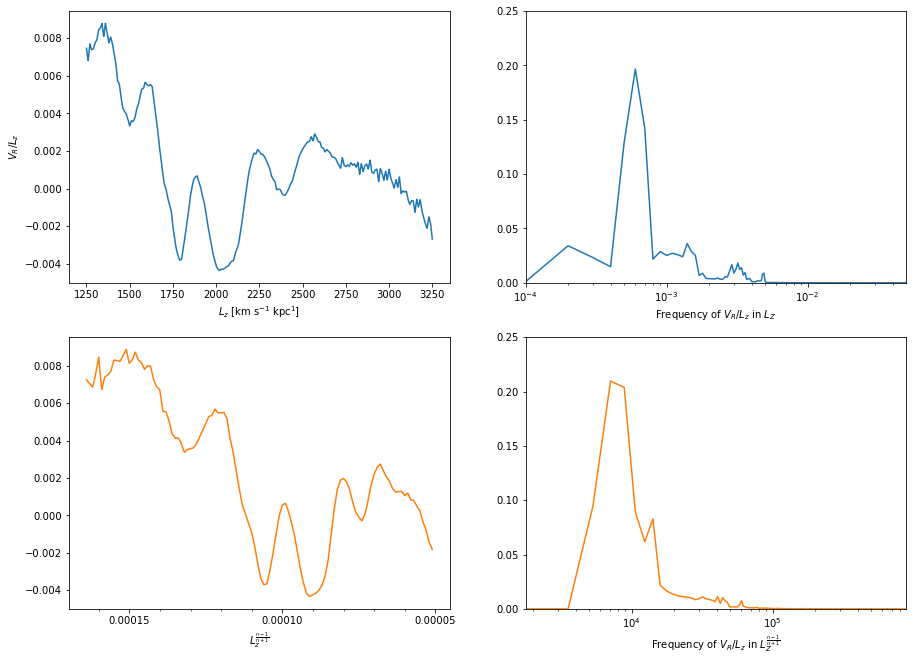

In [364]:
XMIN=1250
XMAX=3250
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2)
DATA = True

fig, ax = plt.subplots(2,2,figsize=(15,11))
#fig = plt.figure(figsize=(15,4))
#subfigs = fig.subfigures(1, 2, wspace=0, width_ratios=(1,2))
#ax = []
#ax.append(subfigs[0].add_subplot(111))
#gs = subfigs[1].add_gridspec(1,2, hspace=0., wspace=0.)
#ax.extend(gs.subplots(sharey=True))
#fig, axs = plt.subplots(1,4,figsize=(15,4))
#gs = axs[1:3].get_gridspec()
#for ax in axs[1:3]:
#    ax.remove()
#ax = axs[0] + gs.subplots(sharey=True)

nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE)
N = 100000
#f = interpolate.interp1d(nx, ny, kind='linear')
#xpol = np.linspace(nx[0], nx[-1], N)
#ypol = f(xpol)
#for i in range(3):
#    ax[i][0].hist2d(Lz[abs(VR)<40], VR[abs(VR)<40], bins=100);
#    ax[i][0].set_aspect('auto')
#    ax[i][0].set_xlabel(r'$L_Z$  [km s$^{-1}$ kpc$^{1}$]')
#    ax[i][0].set_ylabel(r'$V_R$ [km s$^{-1}$] ')

nx, ny = smooth_bins(Lz, VR/Lz, XMIN, XMAX, BINSIZE)
N = 100000
P = 1
f = interpolate.interp1d(nx, ny, kind='linear')
xpol = np.linspace(nx[0], nx[-1], N)
ypol = f(xpol)
xpol = xpol[~np.isnan(ypol)]
ypol = ypol[~np.isnan(ypol)]
N = len(ypol)
#ax_right = ax[0][0].twinx()
#ax_right.plot(xpol, ypol, c='white')
#ax_right.set_ylabel('$L_z/V_R$')
ax[0][0].plot(xpol, ypol, c='C0')
ax[0][0].set_aspect('auto')
#ax[0][0].spines['bottom'].set_color('C0')
#ax[0][0].tick_params(axis='x', colors='C0')
ax[0][0].set_xlabel(r'$L_z$ [km s$^{-1}$ kpc$^{1}$]')
#ax[0][0].xaxis.label.set_color('C0')
ax[0][0].set_ylabel(r'$V_R/L_z$')


ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
sample_rate=1
imf = emd.sift.sift(ypol)
IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'hilbert')
freq_edges, freq_centres = emd.spectra.define_hist_bins(1e-6, 1e-3, 500, 'linear')
#freq_edges, freq_centres = emd.spectra.define_hist_bins(1e-6, 1e-3, 50, 'log')
hht_f, spec = emd.spectra.hilberthuang(IF, IA, freq_edges, scaling='spectrum')
hhtfr = ((nx[-1]-nx[0]) / (hht_f * N))

yf = spec
xfr = hhtfr

print(1/xfr[np.argmax(np.abs(yf))])
ax[0][1].plot(1/xfr, np.abs(yf)/np.sum(np.abs(yf)), color='C0')
ax[0][1].set_xlim(1/max(xfr), 1/min(xfr))
ax[0][1].set_xscale('log')
ax[0][1].set_aspect('auto')
ax[0][1].set_xlabel('Frequency of $V_R/L_z$ in $L_Z$')
ax[0][1].set_ylim(0,0.25)
#ax[0][1].spines['top'].set_color('C1')
#ax[0][1].tick_params(axis='x', colors='C0')
#ax[0][1].xaxis.label.set_color('C0')
print(1/xfr[:10])
avgs = np.sqrt(xfr[1:] * xfr[:-1])
print(1/avgs[:10])

#ax[0][1].errorbar(x=1/xfr[1], y=0.075, xerr=[[abs(1/xfr[1]-1/avgs[0])], [abs(1/xfr[1]-1/avgs[1])]], color='C0', capsize=5)
#ax[0][1].errorbar(x=1/xfr[6], y=0.075, xerr=[[abs(1/xfr[6]-1/avgs[5])], [abs(1/xfr[6]-1/avgs[6])]], color='C0', capsize=5)


n = -0.1
print((n-1)/(n+1))
nx, ny = smooth_bins(Lz**((n-1)/(n+1)), VR/Lz, np.min(Lz**((n-1)/(n+1))), np.max(Lz**((n-1)/(n+1))), 1e-6)
N = 100000
f = interpolate.interp1d(nx, ny, kind='linear')
xpol = np.linspace(nx[0], nx[-1], N)
ypol = f(xpol)
xpol = xpol[~np.isnan(ypol)]
ypol = ypol[~np.isnan(ypol)]
N = len(ypol)
#ax_right = ax[2][0].twiny()
#ax_right.set_xlabel('$L_z^{-1}$')
#ax_right = ax_right.twinx()
#ax_right.plot(xpol, ypol, c='white')
#ax_right.set_ylabel('$L_z/V_R$')
axb = ax[1][0]
axb.plot(xpol, ypol, c='C1')
#axb.spines['top'].set_position(('outward', 40))
#axb.spines['top'].set_color('C1')
#axb.tick_params(axis='x', colors='C1')
axb.set_xlabel(r'$L_z^\frac{n-1}{n+1}$')
#axb.xaxis.label.set_color('C1')
axb.set_xlim(axb.get_xlim()[::-1])
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
axb.xaxis.set_minor_locator(AutoMinorLocator())
#axb.ticklabel_format(style='sci', axis='x', scilimits=(1e-3,1e4))
axb.locator_params(axis='x', nbins=4)


ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
sample_rate=1
imf = emd.sift.sift(ypol)
IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'hilbert')
freq_edges, freq_centres = emd.spectra.define_hist_bins(1e-6, 1e-3, 500, 'linear')
#freq_edges, freq_centres = emd.spectra.define_hist_bins(1e-6, 1e-3, 50, 'log')
hht_f, spec = emd.spectra.hilberthuang(IF, IA, freq_edges, scaling='spectrum')
hhtfr = ((nx[-1]-nx[0]) / (hht_f * N))

yf = spec
xfr = hhtfr

axb = ax[1][1]
axb.plot(1/xfr, np.abs(yf)/np.sum(np.abs(yf)), color='C1')
print(1/xfr[np.argmax(np.abs(yf))])
axb.set_xlim(1/max(xfr), 1/min(xfr))
axb.set_ylim(0,0.25)
axb.set_xscale('log')
#ax[2].xaxis.set_major_formatter(ticker.ScalarFormatter())
axb.set_aspect('auto')
axb.set_xlabel(r'Frequency of $V_R/L_z$ in $L_Z^{\frac{n-1}{n+1}}$')
#axb.spines['top'].set_color('C1')
#axb.tick_params(axis='x', colors='C1')
#axb.xaxis.label.set_color('C1')

print(1/xfr[:10])
avgs = np.sqrt(xfr[1:] * xfr[:-1])
print(1/avgs[:10])
#axb.vlines(x=1/avgs[0], ymin=0, ymax=0.125, c='C1', ls='-')
#axb.axvspan(1/avgs[1], 1/avgs[5], color='C1', alpha=0.2)
#axb.axvspan(0, 1/avgs[0], color='C1', alpha=0.2)

#axb.errorbar(x=0, y=0.075, xerr=[[0], [1/avgs[0]]], color='C1', capsize=5)
#axb.errorbar(x=1/avgs[3], y=0.075, xerr=[[abs(1/avgs[3]-1/avgs[1])], [abs(1/avgs[3]-1/avgs[5])]], color='C1', capsize=5)


#for i in range(1,4):
#    ax[i].set_ylim(0,0.175)


11227.09105410586


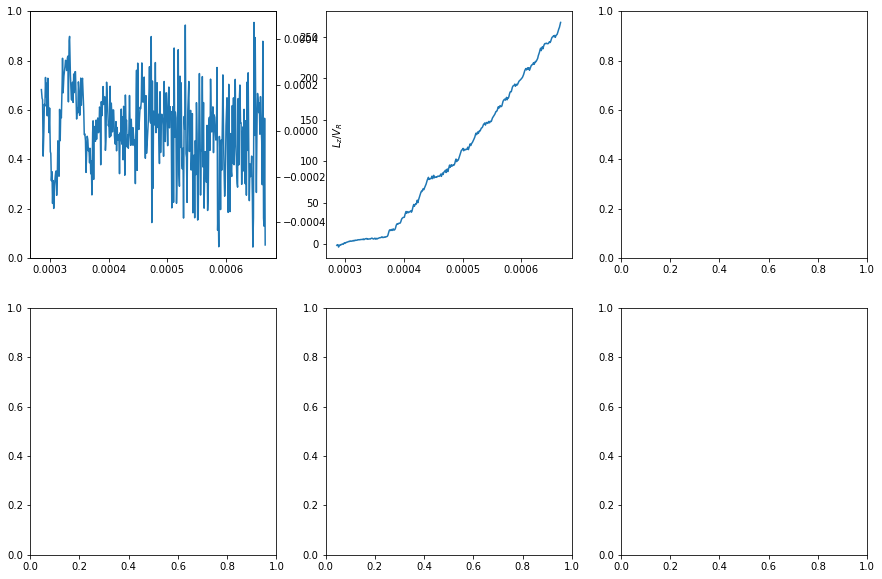

In [209]:

#TIME = 2.5
#TIME = 2.5
#XMIN=1200
#XMAX=3500
#BINSIZE = 10
#x,y,VR,Vphi,R,Lz,phi=l.load_model('Dhot_log', TIME, xmin=XMIN, xmax=XMAX, phi_range=0.2)
#DATA = False

TIME = 3.5
XMIN=1000
XMAX=3500
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_model('MW_Sgr', TIME, xmin=XMIN, xmax=XMAX, phi_range=np.pi)
DATA = False

#XMIN=1000
#XMAX=3000
#BINSIZE = 10
#x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2)
#DATA = True

fig, ax = plt.subplots(2,3,figsize=(15,10))

#nx, ny = smooth_bins(Lz, VR/Lz, XMIN, XMAX, BINSIZE)
#nx, ny = smooth_bins(1/Lz, VR/Lz, np.min(1/Lz), np.max(1/Lz), 1e-6)
nx, ny = smooth_bins(1/Lz, VR/Lz, np.min(1/Lz), 1/1500, 1e-6)
N = 100000
P = 1
f = interpolate.interp1d(nx, ny, kind='linear')
xpol = np.linspace(nx[0], nx[-1], N)
ypol = f(xpol)
xpol = xpol[~np.isnan(ypol)]
ypol = ypol[~np.isnan(ypol)]
N = len(ypol)
ax_right = ax[0][0].twinx()
ax_right.plot(xpol, ypol)
ax_right.set_ylabel('$L_z/V_R$')

from scipy.signal import hilbert
analytic_signal = hilbert(ny)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * N)
ax[0][1].plot(nx, instantaneous_phase)
#ax[0][1].plot(nx[1:], instantaneous_frequency)
kernel_size = 10
kernel = np.ones(kernel_size) / kernel_size
ifs = np.convolve(instantaneous_frequency, kernel, mode='same')
#ax[0][1].plot(nx[1:], ifs)
print(np.mean(instantaneous_frequency))
#XMIN=1200
#XMAX=3500
#BINSIZE = 10
#x,y,VR,Vphi,R,Lz,phi=l.load_model('Dhot_log', TIME, xmin=XMIN, xmax=XMAX, phi_range=0.2)
#DATA = False

TIME = 3.5
XMIN=1000
XMAX=3500
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_model('MW_Sgr', TIME, xmin=XMIN, xmax=XMAX, phi_range=np.pi)
DATA = False

#XMIN=1000
#XMAX=3000
#BINSIZE = 10
#x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2)
#DATA = True

fig, ax = plt.subplots(2,3,figsize=(15,10))

#nx, ny = smooth_bins(Lz, VR/Lz, XMIN, XMAX, BINSIZE)
#nx, ny = smooth_bins(1/Lz, VR/Lz, np.min(1/Lz), np.max(1/Lz), 1e-6)
nx, ny = smooth_bins(1/Lz, VR/Lz, np.min(1/Lz), 1/1500, 1e-6)
N = 100000
P = 1
f = interpolate.interp1d(nx, ny, kind='linear')
xpol = np.linspace(nx[0], nx[-1], N)
ypol = f(xpol)
xpol = xpol[~np.isnan(ypol)]
ypol = ypol[~np.isnan(ypol)]
N = len(ypol)
ax_right = ax[0][0].twinx()
ax_right.plot(xpol, ypol)
ax_right.set_ylabel('$L_z/V_R$')

from scipy.signal import hilbert
analytic_signal = hilbert(ny)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * N)
ax[0][1].plot(nx, instantaneous_phase)
#ax[0][1].plot(nx[1:], instantaneous_frequency)
kernel_size = 10
kernel = np.ones(kernel_size) / kernel_size
ifs = np.convolve(instantaneous_frequency, kernel, mode='same')
#ax[0][1].plot(nx[1:], ifs)
print(np.mean(instantaneous_frequency))

/home/hpc/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',

[  1.47876715   0.         -36.93420132]
/home/hpc/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',

[  1.42728838   0.         -39.26446512]


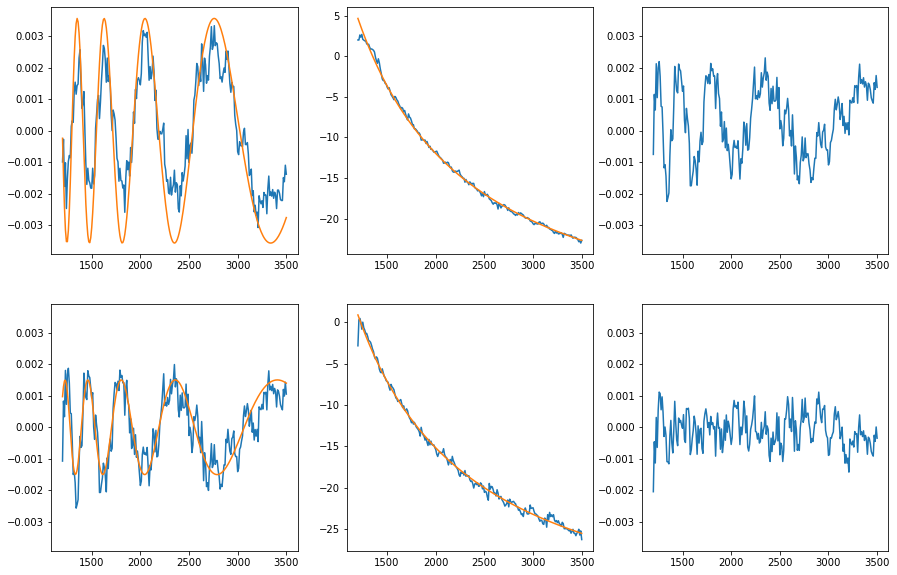

In [405]:

TIME = 1.5
XMIN=1200
XMAX=3500
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_model('Dhot_log', TIME, xmin=XMIN, xmax=XMAX, phi_range=0.2)
DATA = False

#TIME = 3.0
#XMIN=1000
#XMAX=3500
#BINSIZE = 20
#x,y,VR,Vphi,R,Lz,phi=l.load_model('MW_Sgr', TIME, xmin=XMIN, xmax=XMAX, phi_range=np.pi)
#DATA = False

#XMIN=1000
#XMAX=3000
#BINSIZE = 10
#x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2)
#DATA = True

fig, ax = plt.subplots(2,3,figsize=(15,10))

nx, ny = smooth_bins(Lz, VR/Lz, XMIN, XMAX, BINSIZE)
ny -= ny.mean()
#nx, ny = smooth_bins(1/Lz, VR/Lz, np.min(1/Lz), np.max(1/Lz), 1e-6)
#nx, ny = smooth_bins(1/Lz, VR/Lz, np.min(1/Lz), 1/1500, 1e-6)
N = 100000
P = 1
ax[0][0].plot(nx, ny)

from scipy.signal import hilbert
analytic_signal = hilbert(ny)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = -np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * N)
ax[0][1].plot(nx, instantaneous_phase)
#ax[0][1].plot(nx[1:], instantaneous_frequency)
kernel_size = 10
kernel = np.ones(kernel_size) / kernel_size
ifs = np.convolve(instantaneous_frequency, kernel, mode='same')
#ax[0][1].plot(nx[1:], ifs)

def an_phi_mod(Lz, t, n, phi0):
    V0 = 240
    R0 = 8
    pn = 1 - 0.5*np.sqrt(2**(n+1))
    return phi0 + 2 * (V0/(R0)**n)**(2/(1+n)) * pn * t * Lz ** ((n-1)/(1+n))
 
FIXN = 0
fun = lambda Lz, t, n, phi0: an_phi_mod(Lz, t, FIXN, phi0)
#fun = lambda Lz, t, n, phi0: an_phi_mod(Lz, t, n, phi0)
optpar = optimize.curve_fit(fun, nx, instantaneous_phase, p0=[0,FIXN,0], maxfev=10000)[0]
ax[0][1].plot(nx, fun(nx, *optpar))
#ax[0][0].plot(nx, np.sin(fun(nx, *optpar)))
sign = np.max(amplitude_envelope) * np.cos(fun(nx, *optpar))
ax_right.plot(nx, sign, c='C1')
ax[0][0].plot(nx, sign)
ax[0][2].plot(nx, ny - sign)
ax[0][2].set_ylim(ax[0][0].get_ylim())
ax[1][0].set_ylim(ax[0][0].get_ylim())
ax[1][2].set_ylim(ax[0][0].get_ylim())
print(optpar)

ny = ny - sign
ny -= ny.mean()
N = 100000
P = 1
ax[1][0].plot(nx, ny)

from scipy.signal import hilbert
analytic_signal = hilbert(ny)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = -np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * N)
ax[1][1].plot(nx, instantaneous_phase)
#ax[0][1].plot(nx[1:], instantaneous_frequency)
kernel_size = 10
kernel = np.ones(kernel_size) / kernel_size
ifs = np.convolve(instantaneous_frequency, kernel, mode='same')
#ax[0][1].plot(nx[1:], ifs)

def an_phi_mod(Lz, t, n, phi0):
    V0 = 240
    R0 = 8
    pn = 1 - 0.5*np.sqrt(2**(n+1))
    return phi0 + 2 * (V0/(R0)**n)**(2/(1+n)) * pn * t * Lz ** ((n-1)/(1+n))
 
fun = lambda Lz, t, n, phi0: an_phi_mod(Lz, t, FIXN, phi0)
optpar = optimize.curve_fit(fun, nx, instantaneous_phase, p0=[0,FIXN,0], maxfev=10000)[0]
ax[1][1].plot(nx, fun(nx, *optpar))
#ax[0][0].plot(nx, np.sin(fun(nx, *optpar)))
sign = np.max(amplitude_envelope)/2 * np.cos(fun(nx, *optpar))
ax_right.plot(nx, sign, c='C1')
ax[1][0].plot(nx, sign)
ax[1][2].plot(nx, ny - sign)
print(optpar)

/home/hpc/anaconda3/lib/python3.9/site-packages/astropy/table/table.py:3488: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other

/home/hpc/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',

[ 0.37681046  0.054      -9.19709853]
/home/hpc/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',

[  1.40462525   0.054      -37.33507797]


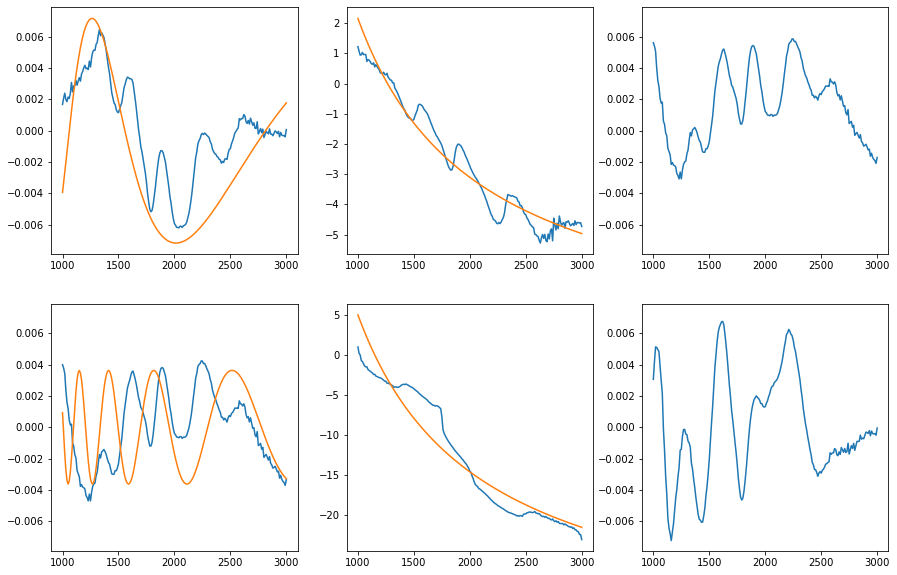

In [27]:

#TIME = 1.5
#XMIN=1200
#XMAX=3500
#BINSIZE = 10
#x,y,VR,Vphi,R,Lz,phi=l.load_model('Dhot_log_2perturb', TIME, xmin=XMIN, xmax=XMAX, phi_range=0.2)
#DATA = False

#TIME = 3.0
#XMIN=1000
#XMAX=3500
#BINSIZE = 20
#x,y,VR,Vphi,R,Lz,phi=l.load_model('MW_Sgr', TIME, xmin=XMIN, xmax=XMAX, phi_range=np.pi)
#DATA = False

XMIN=1000
XMAX=3000
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2, new=True)
DATA = True

fig, ax = plt.subplots(2,3,figsize=(15,10))

nx, ny = smooth_bins(Lz, VR/Lz, XMIN, XMAX, BINSIZE)
ny -= ny.mean()
#nx, ny = smooth_bins(1/Lz, VR/Lz, np.min(1/Lz), np.max(1/Lz), 1e-6)
#nx, ny = smooth_bins(1/Lz, VR/Lz, np.min(1/Lz), 1/1500, 1e-6)
N = 100000
P = 1
ax[0][0].plot(nx, ny)

from scipy.signal import hilbert
analytic_signal = hilbert(ny)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = -np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * N)
ax[0][1].plot(nx, instantaneous_phase)
#ax[0][1].plot(nx[1:], instantaneous_frequency)
kernel_size = 10
kernel = np.ones(kernel_size) / kernel_size
ifs = np.convolve(instantaneous_frequency, kernel, mode='same')
#ax[0][1].plot(nx[1:], ifs)

def an_phi_mod(Lz, t, n, phi0):
    V0 = 240
    R0 = 8
    pn = 1 - 0.5*np.sqrt(2**(n+1))
    return phi0 + 2 * (V0/(R0)**n)**(2/(1+n)) * pn * t * Lz ** ((n-1)/(1+n))
 
#FIXN = -0.1
FIXN = 0.054
fun = lambda Lz, t, n, phi0: an_phi_mod(Lz, t, FIXN, phi0)
#fun = lambda Lz, t, n, phi0: an_phi_mod(Lz, t, n, phi0)
optpar = optimize.curve_fit(fun, nx, instantaneous_phase, p0=[0,FIXN,0], maxfev=10000)[0]
ax[0][1].plot(nx, fun(nx, *optpar))
#ax[0][0].plot(nx, np.sin(fun(nx, *optpar)))
sign = np.max(amplitude_envelope) * np.cos(fun(nx, *optpar))
ax[0][0].plot(nx, sign)
ax[0][2].plot(nx, ny - sign)
ax[0][2].set_ylim(ax[0][0].get_ylim())
ax[1][0].set_ylim(ax[0][0].get_ylim())
ax[1][2].set_ylim(ax[0][0].get_ylim())
print(optpar)

ny = ny - sign
ny -= ny.mean()
N = 100000
P = 1
ax[1][0].plot(nx, ny)

from scipy.signal import hilbert
analytic_signal = hilbert(ny)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = -np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * N)
ax[1][1].plot(nx, instantaneous_phase)
#ax[0][1].plot(nx[1:], instantaneous_frequency)
kernel_size = 10
kernel = np.ones(kernel_size) / kernel_size
ifs = np.convolve(instantaneous_frequency, kernel, mode='same')
#ax[0][1].plot(nx[1:], ifs)

def an_phi_mod(Lz, t, n, phi0):
    V0 = 240
    R0 = 8
    pn = 1 - 0.5*np.sqrt(2**(n+1))
    return phi0 + 2 * (V0/(R0)**n)**(2/(1+n)) * pn * t * Lz ** ((n-1)/(1+n))
 
fun = lambda Lz, t, n, phi0: an_phi_mod(Lz, t, FIXN, phi0)
optpar = optimize.curve_fit(fun, nx, instantaneous_phase, p0=[0,FIXN,0], maxfev=10000)[0]
ax[1][1].plot(nx, fun(nx, *optpar))
#ax[0][0].plot(nx, np.sin(fun(nx, *optpar)))
sign = np.max(amplitude_envelope)/2 * np.cos(fun(nx, *optpar))
ax[1][0].plot(nx, sign)
ax[1][2].plot(nx, ny - sign)
print(optpar)

/home/hpc/anaconda3/lib/python3.9/site-packages/astropy/table/table.py:3488: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other

[ 0.36400189 -8.8604501 ]


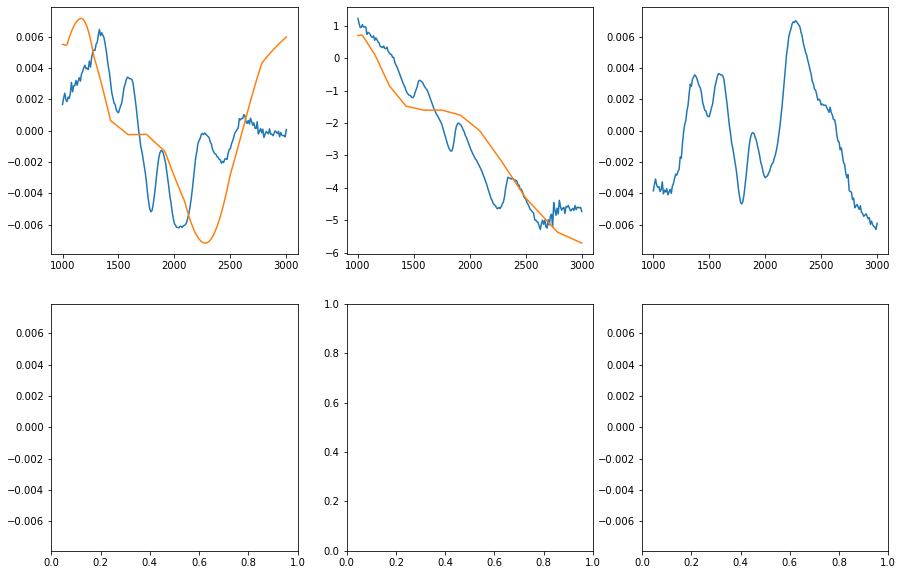

In [32]:

XMIN=1000
XMAX=3000
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2, new=True)
DATA = True

fig, ax = plt.subplots(2,3,figsize=(15,10))

nx, ny = smooth_bins(Lz, VR/Lz, XMIN, XMAX, BINSIZE)
ny -= ny.mean()
N = 100000
ax[0][0].plot(nx, ny)

from scipy.signal import hilbert
analytic_signal = hilbert(ny)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = -np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * N)
ax[0][1].plot(nx, instantaneous_phase)
#ax[0][1].plot(nx[1:], instantaneous_frequency)
kernel_size = 10
kernel = np.ones(kernel_size) / kernel_size
ifs = np.convolve(instantaneous_frequency, kernel, mode='same')
#ax[0][1].plot(nx[1:], ifs)

w = vr/rr
dR = np.gradient(rr)
dw2 = np.gradient(w**2)
k = np.sqrt(rr * dw2/dR + 4 * w**2)
freq = ft*(w - k/2)
#plt.plot(rr, freq)
ffreq = interpolate.interp1d(rr, freq, 'linear')
def phiR(R, t, phi0=0):
    return phi0 + 2*ffreq(R)*t

LzR = rr*vr
rfromlz = interpolate.interp1d(LzR, rr)

def phiR_mod(Lz, t, phi0):
    r = rfromlz(Lz)
    return phiR(r,t,phi0=phi0)

fun = lambda Lz, t, phi0: phiR_mod(Lz, t, phi0)
#fun = lambda Lz, t, n, phi0: an_phi_mod(Lz, t, n, phi0)
optpar = optimize.curve_fit(fun, nx, instantaneous_phase, p0=[0,0], maxfev=10000)[0]
ax[0][1].plot(nx, fun(nx, *optpar))
#ax[0][0].plot(nx, np.sin(fun(nx, *optpar)))
sign = np.max(amplitude_envelope) * np.cos(fun(nx, *optpar))
ax[0][0].plot(nx, sign)
ax[0][2].plot(nx, ny - sign)
ax[0][2].set_ylim(ax[0][0].get_ylim())
ax[1][0].set_ylim(ax[0][0].get_ylim())
ax[1][2].set_ylim(ax[0][0].get_ylim())
print(optpar)

/home/hpc/anaconda3/lib/python3.9/site-packages/astropy/table/table.py:3488: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other



(-0.004222316762368498, 0.004219270063157736)

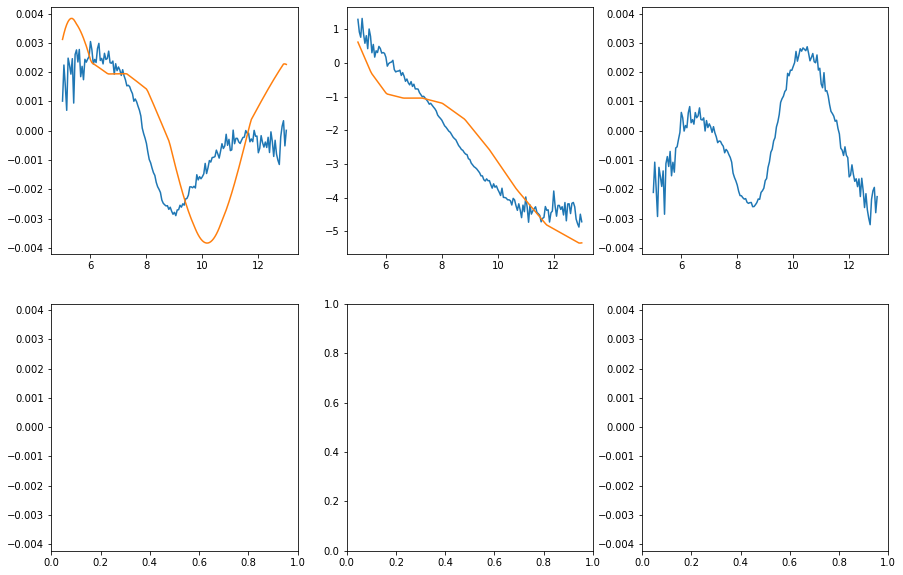

In [403]:

XMIN=1000
XMAX=3000
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2)
DATA = True

fig, ax = plt.subplots(2,3,figsize=(15,10))

nx, ny = smooth_bins(R, VR/Lz, 5, 13, 0.05)
ny -= ny.mean()
N = 100000
ax[0][0].plot(nx, ny)

from scipy.signal import hilbert
analytic_signal = hilbert(ny)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = -np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * N)
ax[0][1].plot(nx, instantaneous_phase)
#ax[0][1].plot(nx[1:], instantaneous_frequency)
kernel_size = 10
kernel = np.ones(kernel_size) / kernel_size
ifs = np.convolve(instantaneous_frequency, kernel, mode='same')
#ax[0][1].plot(nx[1:], ifs)

w = vr/rr
dR = np.gradient(rr)
dw2 = np.gradient(w**2)
k = np.sqrt(rr * dw2/dR + 4 * w**2)
freq = ft*(w - k/2)
#plt.plot(rr, freq)
ffreq = interpolate.interp1d(rr, freq, 'linear')
def phiR(R, t, phi0=0):
    return phi0 + 2*ffreq(R)*t

fun = lambda R, t, phi0: phiR(R, t, phi0)
#fun = lambda Lz, t, n, phi0: an_phi_mod(Lz, t, n, phi0)
optpar = optimize.curve_fit(fun, nx, instantaneous_phase, p0=[0,0], maxfev=10000)[0]
ax[0][1].plot(nx, fun(nx, *optpar))
#ax[0][0].plot(nx, np.sin(fun(nx, *optpar)))
sign = np.max(amplitude_envelope) * np.cos(fun(nx, *optpar))
ax_right.plot(nx, sign, c='C1')
ax[0][0].plot(nx, sign)
ax[0][2].plot(nx, ny - sign)
ax[0][2].set_ylim(ax[0][0].get_ylim())
ax[1][0].set_ylim(ax[0][0].get_ylim())
ax[1][2].set_ylim(ax[0][0].get_ylim())
#print(optpar)